## Objectives

-Preprocess, analyze, detect and treat several anomalies using multiple techniques on the battery charge/discharge dataset obtained from NASA.

## Data Dictionary

- Voltage_measured: Fuel Cell terminal voltage (Volts)
- Current_measured: Fuel Cell output current (Amps)
- Temperature_measured: Fuel Cell temperature (degree C)
- Current_load: Current measured at load (Amps)
- Voltage_load: Voltage measured at load (Volts)
- Time: Time vector for the cycle (seconds)
- Capacity: Fuel Cell capacity (Ahr) for discharge till 2.7V
- Datetime: the date and time of the start of the cycle
- Ambient_temperature: Temperature in which the fuel cell is stored (degree C)
- Cycle: Charge cycle of the fuel cell

## Data Description

- A set of four Fuel cells (# 5, 6, 7 and 18) were run through 2 different operational profiles (charge& discharge) at room temperature. Charging was carried out in a constant current (CC) mode at 1.5A until the Fuel cell voltage reached 4.2V and then continued in a constant voltage (CV) mode until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for Fuel cell 5 6 7 and 18 respectively.

- Repeated charge and discharge cycles result in accelerated aging of the Fuel cell. The experiments were stopped when the Fuel cell reached end-of-life (EOL) criteria, which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr).

- This data can be further used for the prediction of both remaining charge (for a given discharge cycle) and remaining useful life (RUL).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
import os

warnings.filterwarnings('ignore')

In [2]:
def load_data(file, battery):
    mat = loadmat(file)
    print('Total data in dataset:', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset, capacity_data = [], []

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(
                int(row['time'][0][0]), int(row['time'][0][1]),
                int(row['time'][0][2]), int(row['time'][0][3]),
                int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([
                    counter+1, ambient_temperature, date_time, capacity,
                    voltage_measured, current_measured, temperature_measured,
                    current_load, voltage_load, time
                ])
                capacity_data.append([counter+1, ambient_temperature, date_time, capacity])
                counter += 1
    return [
        pd.DataFrame(data=dataset, columns=[
            'cycle', 'ambient_temperature', 'datetime', 'capacity', 'voltage_measured',
            'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time'
        ]),
        pd.DataFrame(data=capacity_data, columns=[
            'cycle', 'ambient_temperature', 'datetime', 'capacity'])
    ]

In [3]:
B0005_dataset, B005_capacity = load_data('battery_dataset/1. BatteryAgingARC-FY08Q4/B0005.mat', 'B0005')
B0005_dataset['flag'] = 1

B0006_dataset, B006_capacity = load_data('battery_dataset/1. BatteryAgingARC-FY08Q4/B0006.mat', 'B0006')
B0006_dataset['flag'] = 2

B0007_dataset, B007_capacity = load_data('battery_dataset/1. BatteryAgingARC-FY08Q4/B0007.mat', 'B0007')
B0007_dataset['flag'] = 3

B0018_dataset, B0018_capacity = load_data('battery_dataset/1. BatteryAgingARC-FY08Q4/B0018.mat', 'B0018')
B0018_dataset['flag'] = 4

Total data in dataset: 616
Total data in dataset: 616
Total data in dataset: 616
Total data in dataset: 319


In [4]:
fuel_cells_df = pd.concat([B0005_dataset, B0006_dataset, B0007_dataset, B0018_dataset],
                          ignore_index=True)

fuel_cells_df.head(10)

cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      2                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      3                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      4                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      5                   24 2008-04-02 15:25:41  1.856487          3.934352   
5      6                   24 2008-04-02 15:25:41  1.856487          3.920058   
6      7                   24 2008-04-02 15:25:41  1.856487          3.907904   
7      8                   24 2008-04-02 15:25:41  1.856487          3.897036   
8      9                   24 2008-04-02 15:25:41  1.856487          3.887477   
9     10                   24 2008-04-02 15:25:41  1.856487          3.878959   

   current_measured  temperature_measured  current_load  voltage_load  \
0         -0.004902             24.330034       -0.0006         0.000   
1         -0.001478             24.325993       -0.0006         4.206   
2         -2.012528             24.389085       -1.9982         3.062   
3         -2.013979             24.544752       -1.9982         3.030   
4         -2.011144             24.731385       -1.9982         3.011   
5         -2.013007             24.909816       -1.9982         2.991   
6         -2.014400             25.105884       -1.9982         2.977   
7         -2.011603             25.317019       -1.9982         2.967   
8         -2.018015             25.509423       -1.9982         2.959   
9         -2.013135             25.703603       -1.9982         2.951   

      time  flag  
0    0.000     1  
1   16.781     1  
2   35.703     1  
3   53.781     1  
4   71.922     1  
5   90.094     1  
6  108.281     1  
7  126.453     1  
8  144.641     1  
9  162.844     1

In [5]:
fuel_cells_df.shape

(185721, 11)

In [6]:
fuel_cells_df.columns

Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

In [7]:
fuel_cells_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185721 entries, 0 to 185720
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cycle                 185721 non-null  int64         
 1   ambient_temperature   185721 non-null  uint8         
 2   datetime              185721 non-null  datetime64[ns]
 3   capacity              185721 non-null  float64       
 4   voltage_measured      185721 non-null  float64       
 5   current_measured      185721 non-null  float64       
 6   temperature_measured  185721 non-null  float64       
 7   current_load          185721 non-null  float64       
 8   voltage_load          185721 non-null  float64       
 9   time                  185721 non-null  float64       
 10  flag                  185721 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), uint8(1)
memory usage: 14.3 MB


In [8]:
for i in fuel_cells_df.columns:
    print(i, ':', fuel_cells_df[i].nunique())

cycle : 50285
ambient_temperature : 1
datetime : 300
capacity : 636
voltage_measured : 185721
current_measured : 185721
temperature_measured : 185721
current_load : 21
voltage_load : 1835
time : 62016
flag : 4


In [9]:
fuel_cells_df.drop('ambient_temperature', axis=1, inplace=True)

In [10]:
fuel_cells_df.isnull().sum()

cycle                   0
datetime                0
capacity                0
voltage_measured        0
current_measured        0
temperature_measured    0
current_load            0
voltage_load            0
time                    0
flag                    0
dtype: int64

#### Univariate Analysis


In [11]:
def numerical_feature(df, colname, nrows=2, ncols=2, width=15, height=70):
    fig, ax = plt.subplots(nrows, ncols, figsize=(width, height))
    for rows, var in enumerate(colname):
        ax[rows][0].set_title('Boxplot for Outlier Detection', fontweight='bold')
        plt.ylabel(var, fontsize=12)
        sns.boxplot(y=df[var], color='crimson', ax=ax[rows][0])
        sns.histplot(df[var], color='purple', ax=ax[rows][1], kde=True)
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label='Mean')
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label='Median')
        ax[rows][1].axvline(df[var].mode()[0], color='b', linestyle='-', label='Mode')
        ax[rows][1].set_title('Outlier Detection', fontweight='bold')
        ax[rows][1].legend({'Mean': df[var].mean(), 'Median': df[var].median(), 'Mode': df[var].mode()})
    
    plt.show()

In [12]:
fuel_cells_df.columns

Index(['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag'],
      dtype='object')

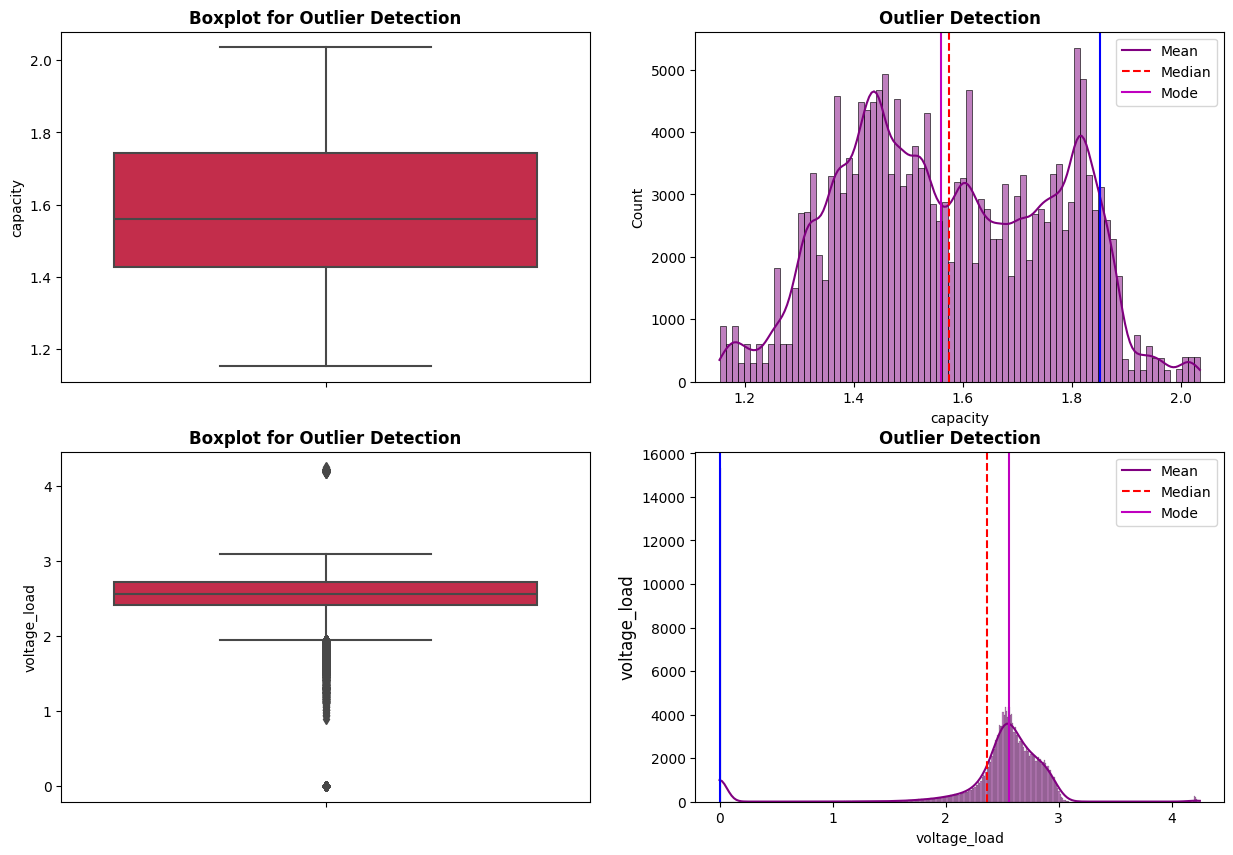

In [13]:
numerical_cols = ['capacity', 'voltage_load']

numerical_feature(fuel_cells_df, numerical_cols, len(numerical_cols), 2, 15, 10)

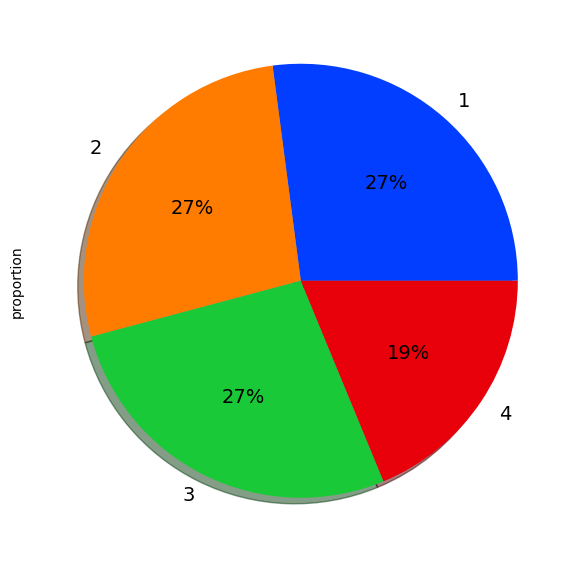

In [14]:
categorical_cols = ['flag']

plt.figure(figsize=(7, 8))
count = fuel_cells_df['flag'].value_counts(normalize=True) * 100
count.plot.pie(colors=sns.color_palette('bright'), autopct='%0.0f%%',
               textprops={'fontsize': 14}, shadow=True)
plt.show()

### Bivariate Analysis


1. Capacity with respect to Cycle


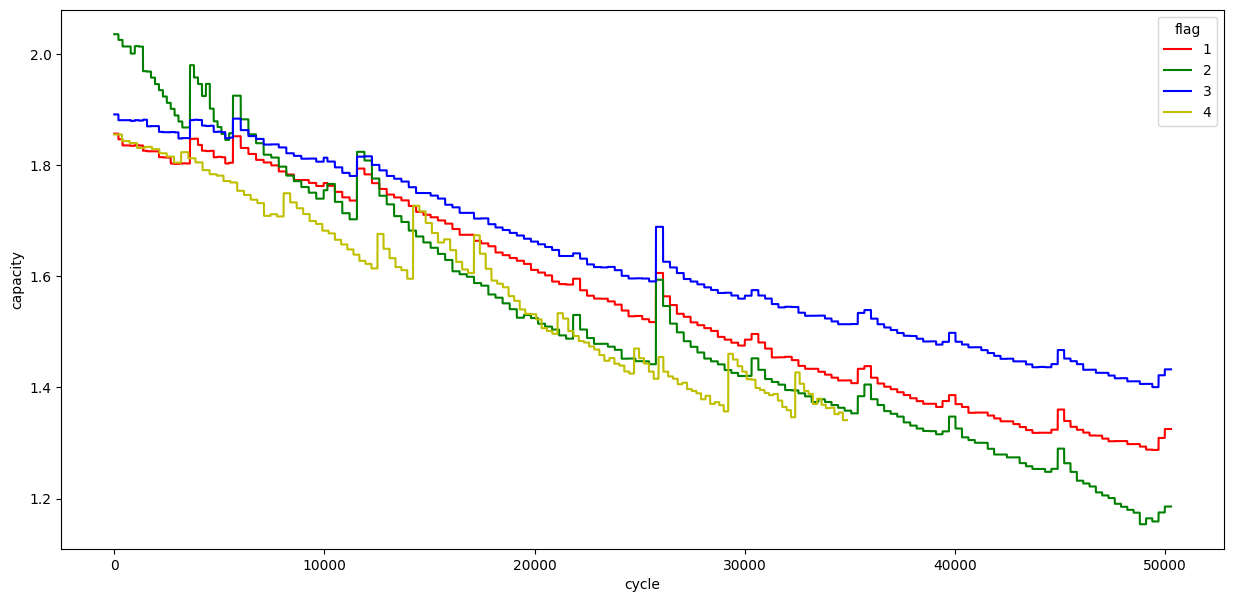

In [15]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='cycle', y='capacity', data=fuel_cells_df, 
             palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- As the cycle increases, the battery capacities is showing a decreasing trend
- Capacity of batteries decrease as number of cycles of battery usage increase


2. Datetime with respect to time


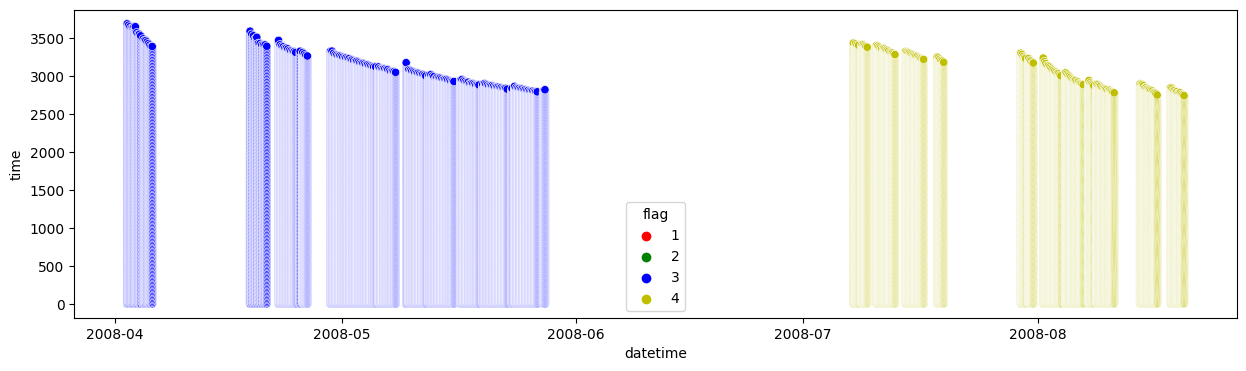

In [16]:
plt.figure(figsize=(15, 4))
sns.scatterplot(x='datetime', y='time', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- There has not been continuous testing of charging of batteries throughout the cycles.
- First 3 batteries (5, 6, 7) have been charged/tested synchronously whereas the 4th battery (B0018) is charged/tested post July 2008 with a couple of breaks between them
- The general trend is more or less the same which is as time of battery's cycle of charging decreases over a period of time.


3. Datetime with respect to capacity


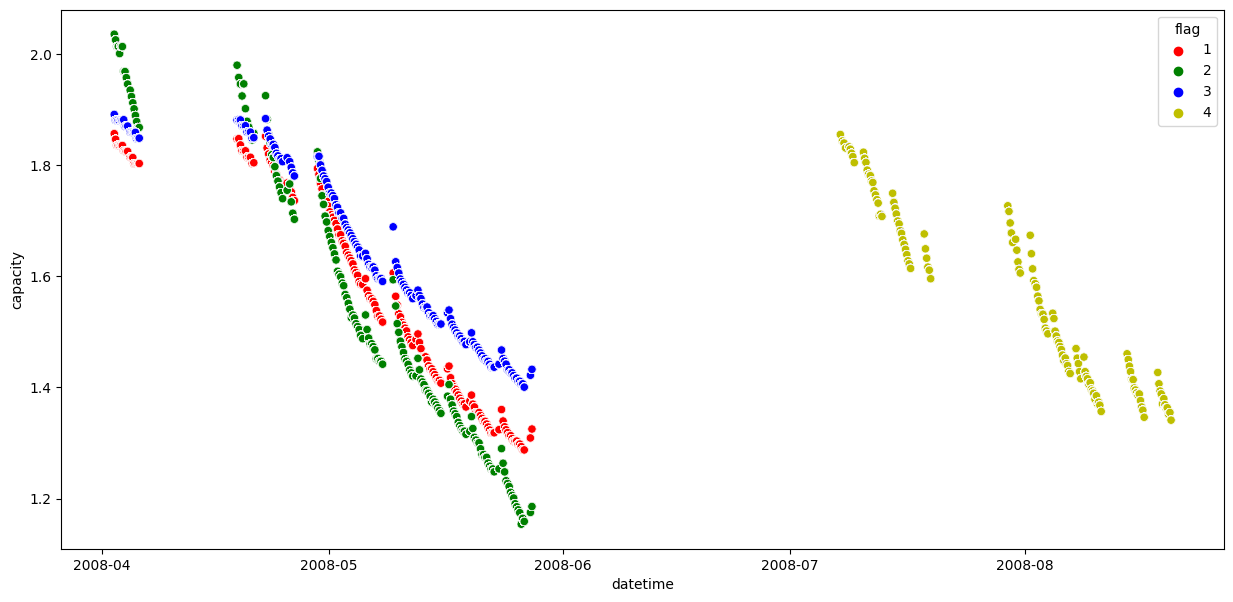

In [17]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x='datetime', y='capacity', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- Capacity decreases over a period of time.
- We can clearly see that, Battery (B0018) has been launched recently and is having average capacity over time.
- Capacity of Battery B0006 deteriorates the most over time whereas for B0007 it's most efficient in terms of capacity over a period of time.


4. Capacity with respect to time


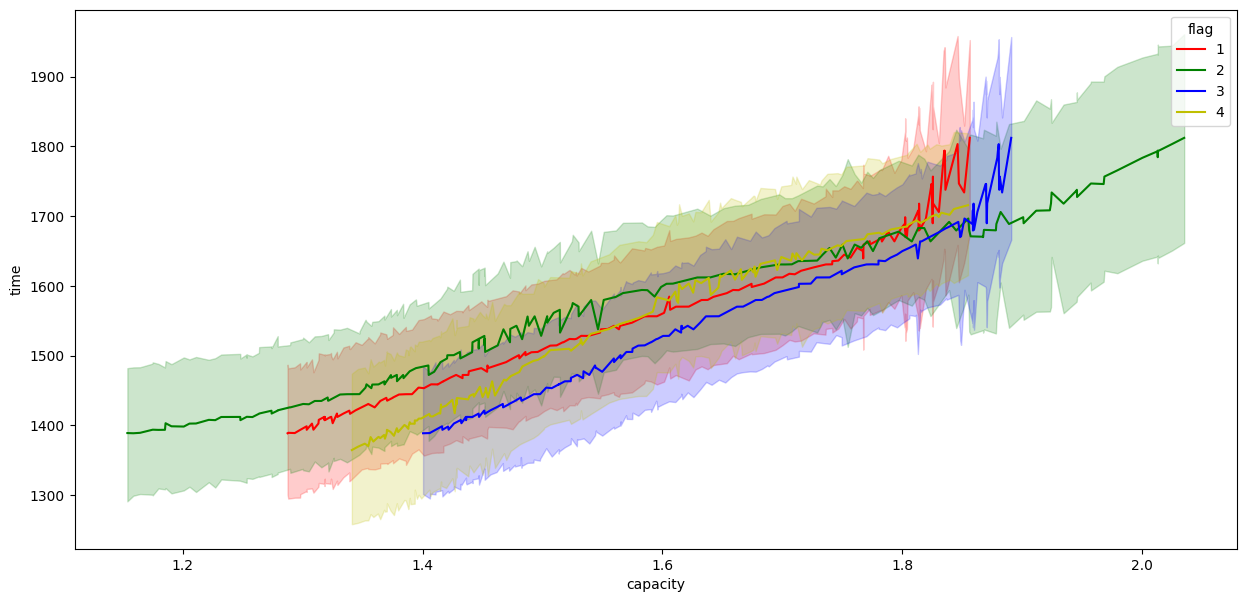

In [18]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='capacity', y='time', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- As the time to charge the batteries is increasing, the capacity is also increasing for all the batteries


5. Temperature with respect to Time


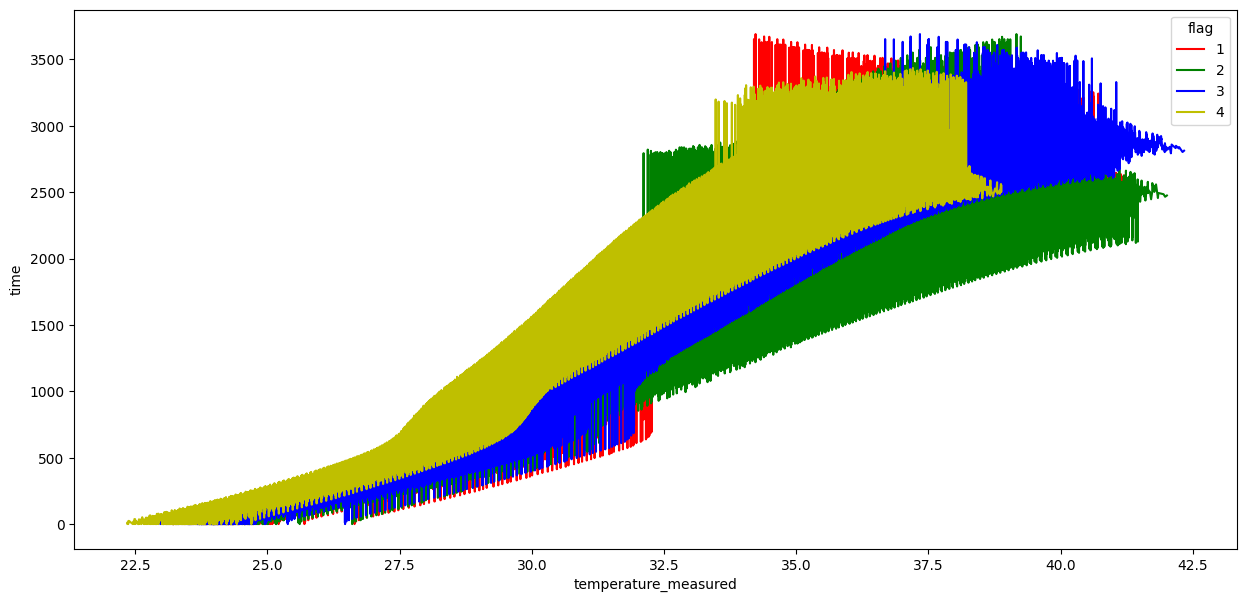

In [19]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='temperature_measured', y='time', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- As the time increases for batteries, the depreciation increases because, _temperature_measured_ increases in every
  cycle of charging.
- As clearly visible, Battery B0006 has maximum number of outliers


6. Voltage measured with respect to time


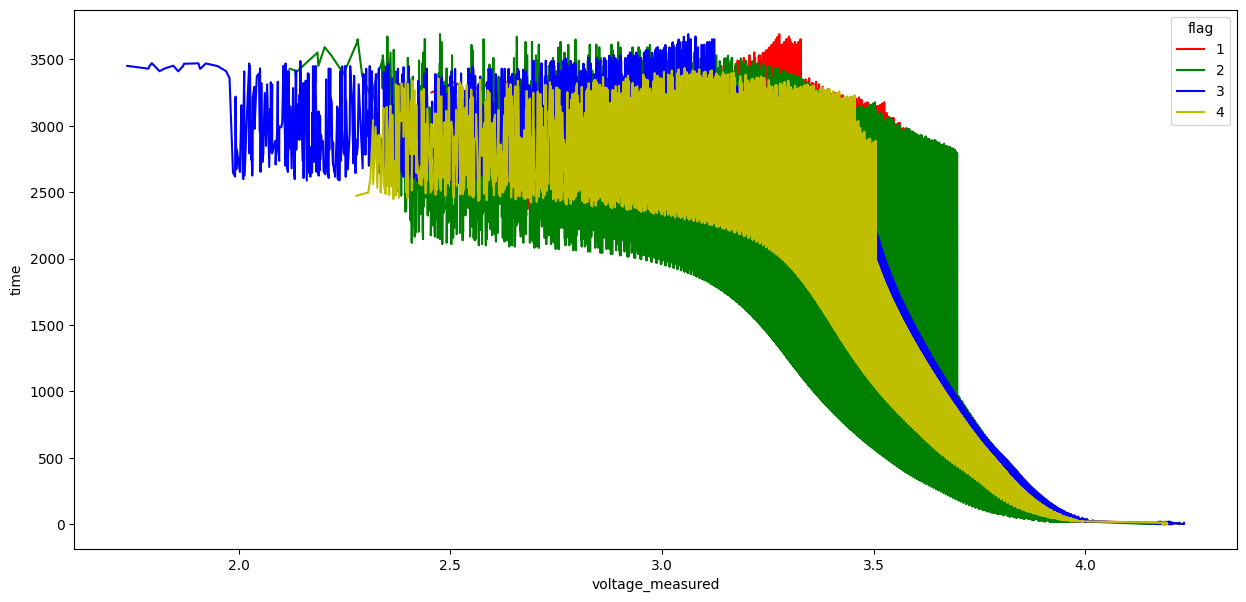

In [20]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='voltage_measured', y='time', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show()

- Battery B0006 has maximum number of outliers


7. Current measured with respect to time


AttributeError: 'numpy.int64' object has no attribute 'startswith'

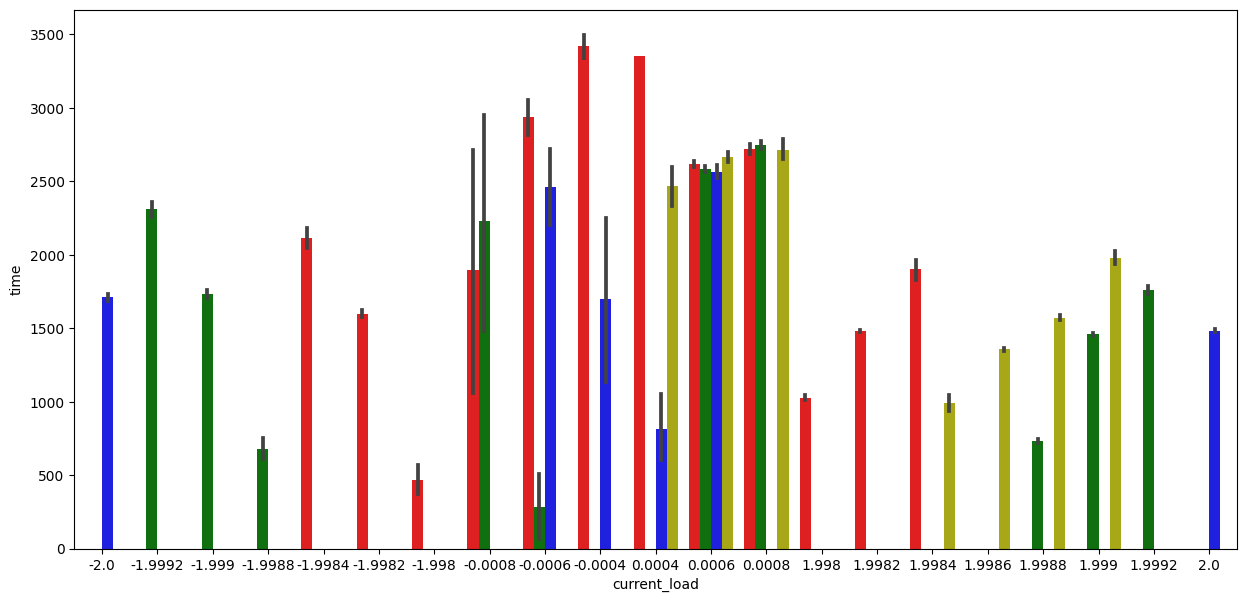

In [21]:
plt.figure(figsize=(15, 7))
sns.barplot(x='current_load', y='time', data=fuel_cells_df, 
                palette=['r', 'g', 'b', 'y'], hue='flag')
plt.show();

- Battery B0006 has maximum number of outliers


8. Correlation between various features


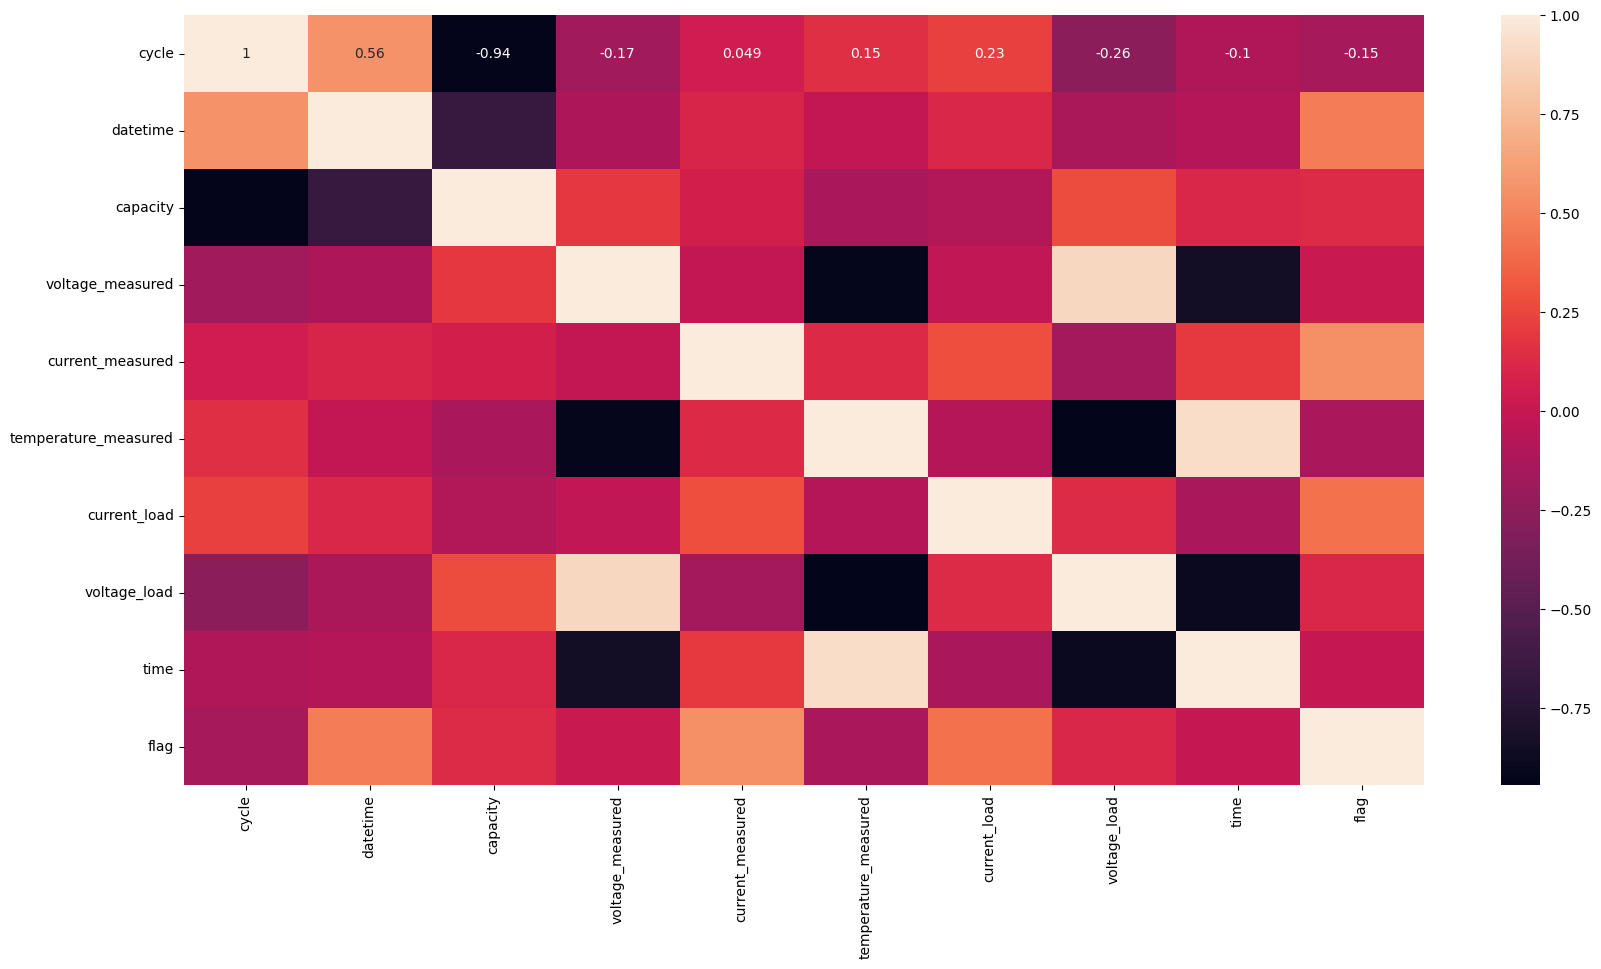

In [22]:
fig, ax = plt.subplots(figsize = (20,10))
sns.heatmap(fuel_cells_df.corr(method='spearman'), annot=True)
plt.show()

- cycle & capacity -> negatively correlated.
- volatage load and voltage_measured -> negatively correlated.
- voltage_measured and time -> positively correlated.
- temperature and time -> positively correlated.


## Visual analysis using traditional methods of anomaly detection

1. IQR
2. DBSCAN


#### IQR-based anomaly detection


In [23]:
num_cols_1 = ['capacity', 'voltage_measured', 'voltage_load']
num_cols_2 = ['current_measured', 'current_load']
temp = ['temperature_measured']
num_cols_3 = ['cycle', 'time']

In [24]:
Q1 = fuel_cells_df.quantile(0.25)
Q3 = fuel_cells_df.quantile(0.75)

IQR = Q3 - Q1
print(IQR)

cycle                            23215.0
datetime                23 days 02:10:03
capacity                        0.315825
voltage_measured                0.278098
current_measured                0.021444
temperature_measured            5.850056
current_load                      0.0008
voltage_load                       0.308
time                            1542.688
flag                                 2.0
dtype: object


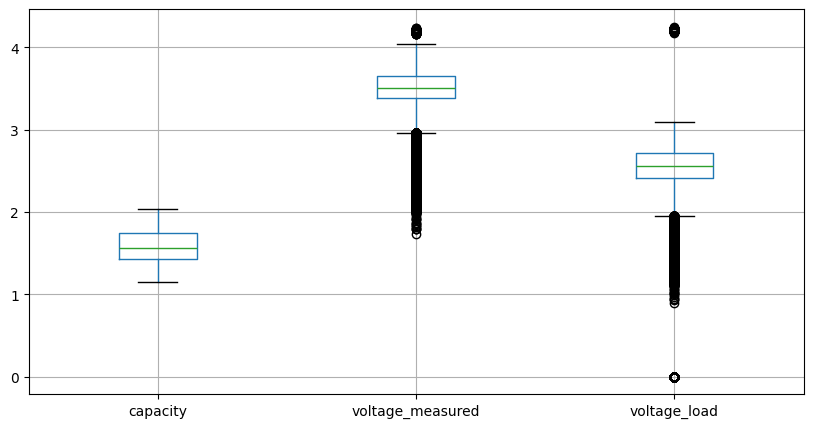

In [25]:
fuel_cells_df[num_cols_1].boxplot(figsize=(10, 5))
plt.show()

- _voltage_measured_, _voltage_load_ have more number of outliers below the lower whisker


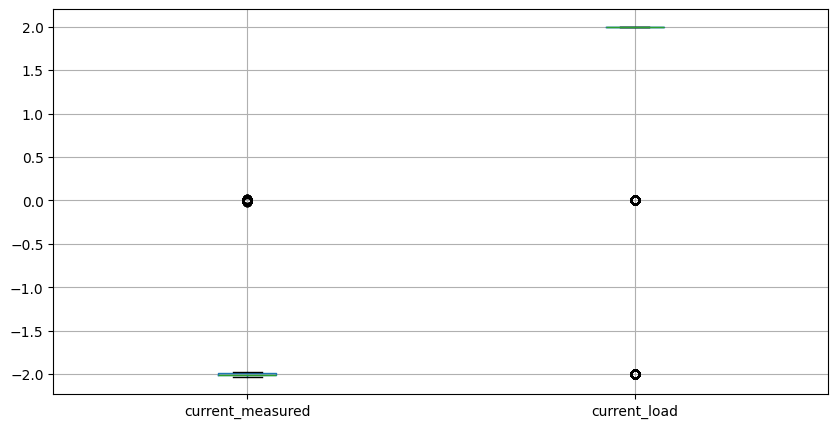

In [26]:
fuel_cells_df[num_cols_2].boxplot(figsize=(10, 5))
plt.show()

- As the dataponts are less, the IQR range is very small, but some outliers are present for _current_measured_, _current_load_


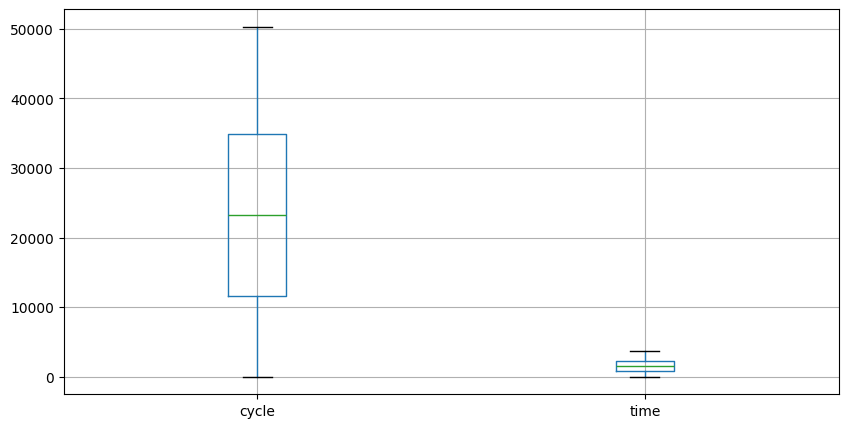

In [27]:
fuel_cells_df[num_cols_3].boxplot(figsize=(10, 5))
plt.show()

- All other features are having very less outliers


In [28]:
num_cols = ['cycle', 'capacity', 'voltage_measured', 'current_measured',
                  'temperature_measured', 'current_load', 'voltage_load', 'time']

fuel_cells_df1 = fuel_cells_df.copy()

Outliers treatment using IQR-based methods


In [29]:
fuel_cells_df1 = fuel_cells_df1[~((fuel_cells_df1[num_cols] < (Q1 - 1.5*IQR)[num_cols]) | (fuel_cells_df1[num_cols] > (Q3 +1.5*IQR)[num_cols])).any(axis = 1)]
fuel_cells_df1 = fuel_cells_df1.reset_index(drop = True)

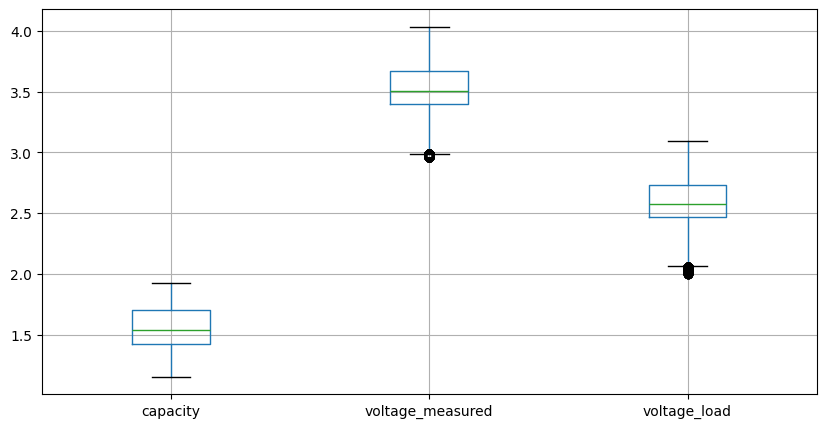

In [30]:
fuel_cells_df1[num_cols_1].boxplot(figsize = (10,5))
plt.show()

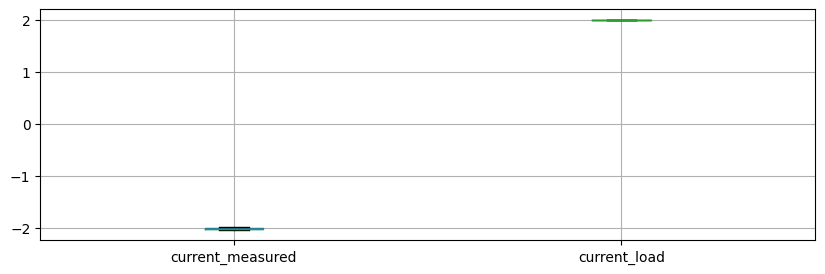

In [31]:
fuel_cells_df1[num_cols_2].boxplot(figsize = (10,3))
plt.show()

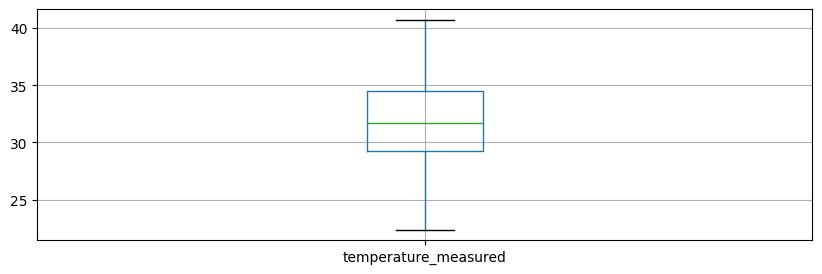

In [32]:
fuel_cells_df1[temp].boxplot(figsize = (10,3))
plt.show()

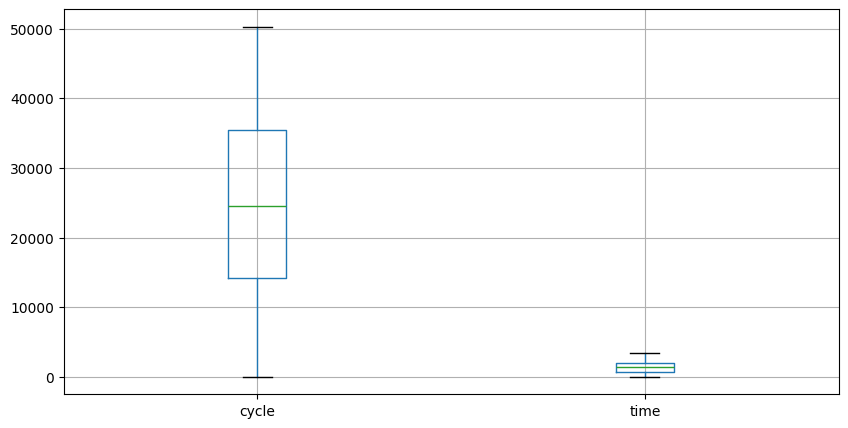

In [33]:
fuel_cells_df1[num_cols_3].boxplot(figsize = (10,5))
plt.show()

In [34]:
fuel_cells_df1.shape[0] - fuel_cells_df.shape[0]

-37766

- As we can see, total 37,766 datapoints are eliminated using IQR based method.
- This might contain some useful data as well, so it's better to treat/ detect outliers with some robust and SOTA methods of anomaly detection


In [35]:
fuel_cells_df_copy1 = fuel_cells_df.copy()

In [36]:
fuel_cells_df['datetime'] = fuel_cells_df['datetime'].astype('int64')
fuel_cells_df['datetime'].head()

fuel_cells_df_copy2 = fuel_cells_df.copy()

#### DBSCAN-based anomaly detection


In [37]:
from sklearn.cluster import DBSCAN

cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']

std_scaler = StandardScaler().fit(fuel_cells_df_copy2)
std_df = std_scaler.transform(fuel_cells_df_copy2)

dbsc = DBSCAN(eps=0.5, min_samples=200).fit(std_df)

labels = dbsc.labels_

In [38]:
out_df = fuel_cells_df_copy2.copy()
out_df['label'] = dbsc.labels_

In [39]:
count_df = pd.DataFrame(data = out_df['label'].value_counts().values, columns = ['label_counts'])
count_df

label_counts
0          41652
1          39197
2          37765
3          31177
4           8009
5           5394
6           5292
7           5209
8           4825
9           4202
10          1991
11          1008

In [40]:
index_df = pd.DataFrame(out_df['label'].value_counts().index)
index_df

label
0       7
1       1
2       4
3       9
4      -1
5       6
6       3
7       0
8       5
9       2
10     10
11      8

In [41]:
label_counts_df = pd.concat([index_df,count_df], axis = 1)
label_counts_df

label  label_counts
0       7         41652
1       1         39197
2       4         37765
3       9         31177
4      -1          8009
5       6          5394
6       3          5292
7       0          5209
8       5          4825
9       2          4202
10     10          1991
11      8          1008

In [42]:
out_df

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           2  1207149941000000000  1.856487          4.190749   
2           3  1207149941000000000  1.856487          3.974871   
3           4  1207149941000000000  1.856487          3.951717   
4           5  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716  34862  1219221439000000000  1.341051          3.443760   
185717  34863  1219221439000000000  1.341051          3.453271   
185718  34864  1219221439000000000  1.341051          3.461963   
185719  34865  1219221439000000000  1.341051          3.469907   
185720  34866  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  label  
0          0.000     1     -1  
1         16.781     1     -1  
2         35.703     1      0  
3         53.781     1      0  
4         71.922     1      0  
...          ...   ...    ...  
185716  2686.359     4     10  
185717  2700.546     4     10  
185718  2714.640     4     10  
185719  2728.750     4     10  
185720  2742.843     4     10  

[185721 rows x 11 columns]

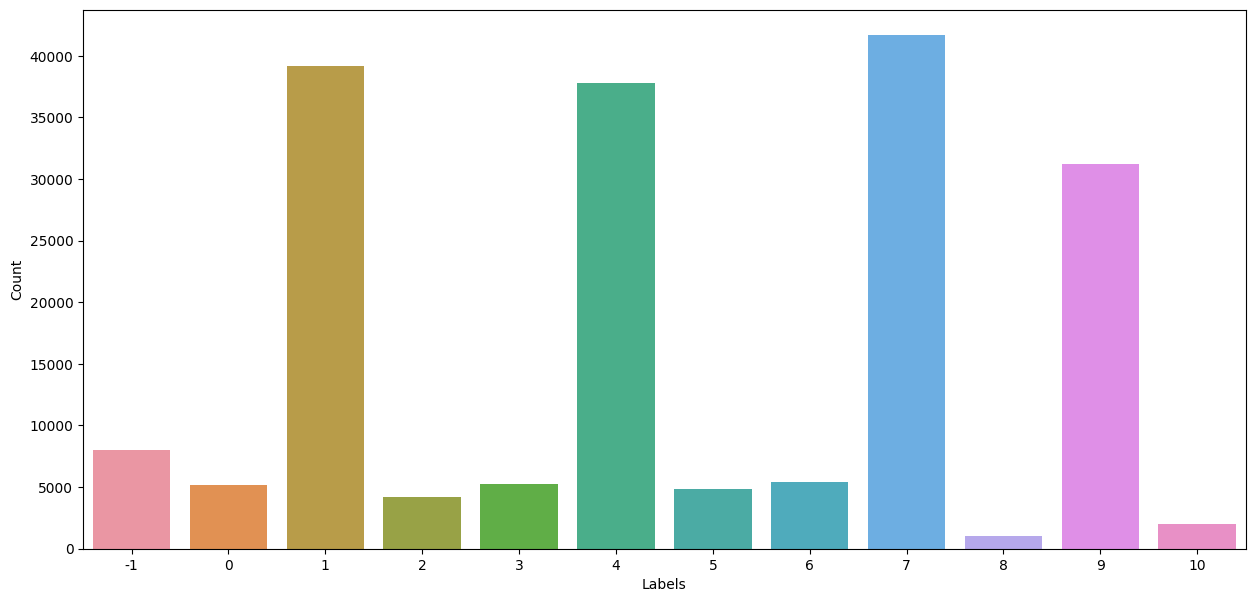

In [43]:
plt.figure(figsize=(15, 7))
sns.barplot(x = 'label', y = 'label_counts', data = label_counts_df)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

- As we can see, when all features are considered, the datapoints corresponding to -1 (noisy data) are 8009
- lets' further check with visualization and DBSCAN on other two features.
- It's running with very high time complexity and hence we have visualised on 10k samples.


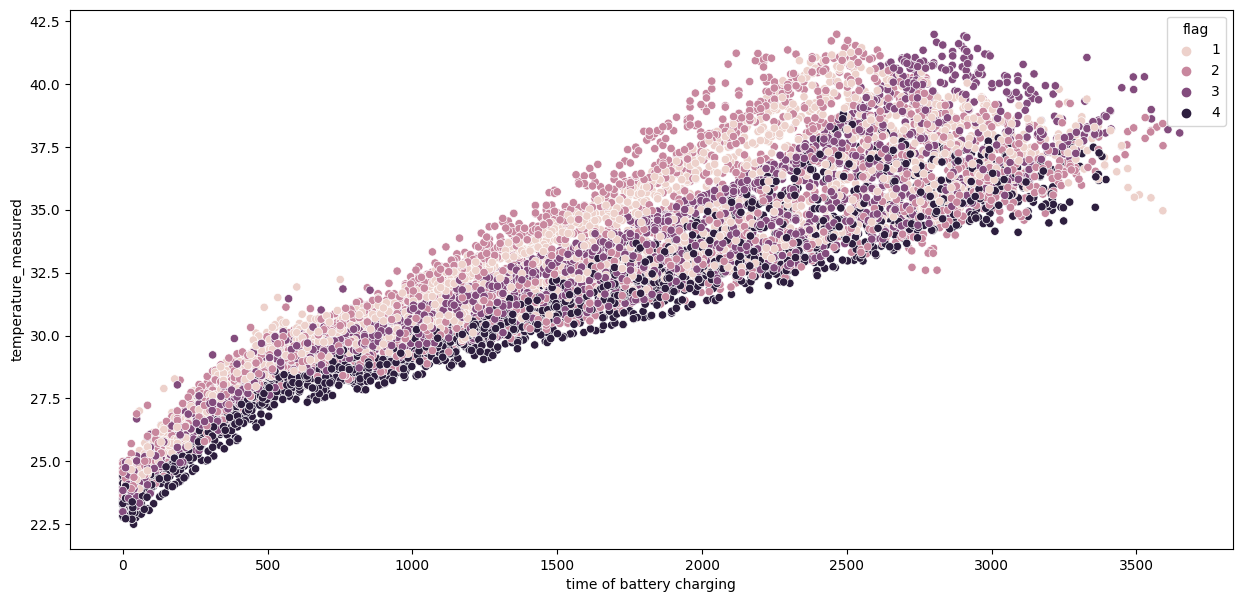

In [44]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'temperature_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('temperature_measured')
plt.show()

- We can hardly see any outliers present when visualized with these two features.
- Lets cross check with some other two features


In [45]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x = 'time', y = 'voltage_measured', hue ='flag', data = out_df.sample(n = 10000, replace = True))
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

In [46]:
df = fuel_cells_df_copy2[['time','voltage_measured']].sample(n = 10000, replace = True)

std_scaler = StandardScaler().fit(df)
std_df = std_scaler.transform(df)

dbsc = DBSCAN(eps = .5, min_samples = 200).fit(std_df)

labels = dbsc.labels_

In [47]:
out_df = df.copy()
out_df['label'] = dbsc.labels_

out_df['label'].value_counts()

label
 0    9807
-1     193
Name: count, dtype: int64

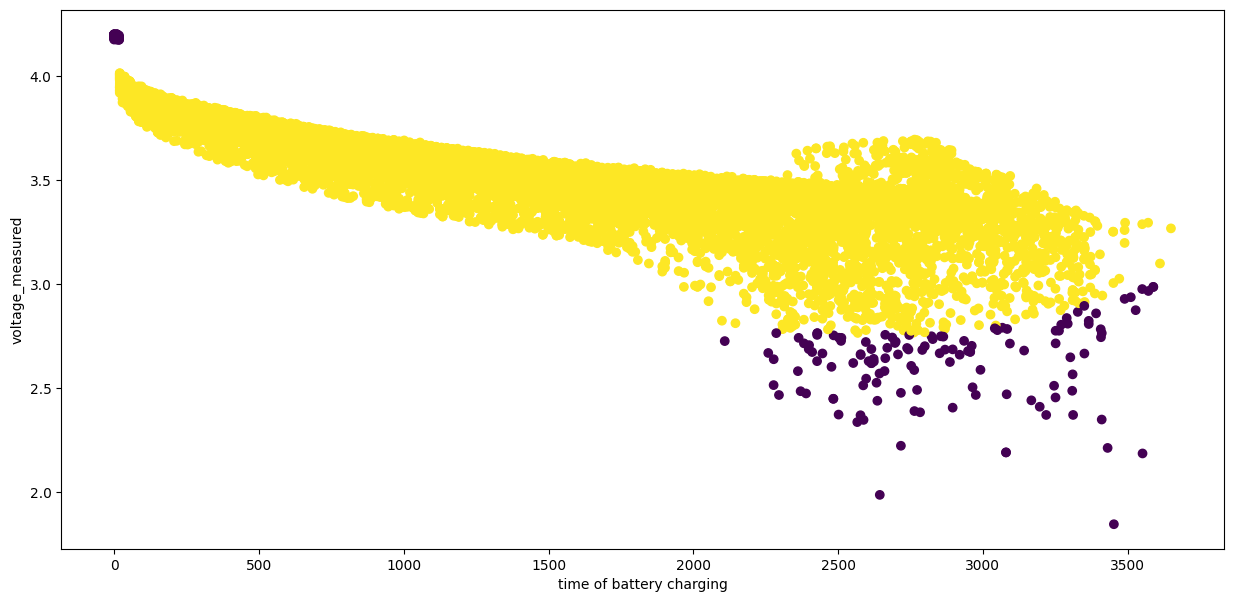

In [48]:
plt.figure(figsize=(15, 7))
plt.scatter(out_df['time'], out_df['voltage_measured'], c=out_df['label'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- With DBSCAN, we are clearly able to see the cluster for noise points in purple.
- The total no. of outliers are 8009


MinMax Scaling


In [49]:
cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
mm_scaler = MinMaxScaler()

fuel_cells_df[cols] = mm_scaler.fit_transform(fuel_cells_df[cols])
fuel_cells_df.head()

cycle  datetime  capacity  voltage_measured  current_measured  \
0  0.00000       0.0  0.797111          0.983242          0.990600   
1  0.00002       0.0  0.797111          0.982944          0.992276   
2  0.00004       0.0  0.797111          0.896465          0.008109   
3  0.00006       0.0  0.797111          0.887189          0.007399   
4  0.00008       0.0  0.797111          0.880233          0.008787   

   temperature_measured  current_load  voltage_load      time  flag  
0              0.099077       0.49985      0.000000  0.000000   0.0  
1              0.098875       0.49985      0.989880  0.004547   0.0  
2              0.102032       0.00045      0.720640  0.009675   0.0  
3              0.109822       0.00045      0.713109  0.014574   0.0  
4              0.119162       0.00045      0.708637  0.019490   0.0

### Isolation Forest based anomaly detection


In [50]:
fuel_cells_df['flag'].unique()

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [54]:
from sklearn.ensemble import IsolationForest

flag_df, flag_df_final = pd.DataFrame(), pd.DataFrame()
contamination_arr = [0.01, 0.02, 0.03, 0.04]

for j in fuel_cells_df['flag'].unique():
    flag_df = fuel_cells_df[fuel_cells_df['flag'] == j]
    for i in contamination_arr:
        model = IsolationForest(n_estimators = 200, contamination = i, random_state = 42)
        flag_df['anomaly_score_'+str(i)] = model.fit_predict(flag_df)
        flag_df['scores_' + str(i)]  = model.decision_function(flag_df[flag_df.columns.drop(['anomaly_score_'+str(i)])])
    flag_df_final = pd.concat([flag_df, flag_df_final])

0.01 0.0
0.02 0.0
0.03 0.0
0.04 0.0
0.01 0.3333333333333333
0.02 0.3333333333333333
0.03 0.3333333333333333
0.04 0.3333333333333333
0.01 0.6666666666666667
0.02 0.6666666666666667
0.03 0.6666666666666667
0.04 0.6666666666666667
0.01 1.0
0.02 1.0
0.03 1.0
0.04 1.0


In [55]:
flag_df_final['anomaly_score_0.01'].value_counts(ascending= True)

anomaly_score_0.01
-1      1858
 1    183863
Name: count, dtype: int64

In [56]:
for i in contamination_arr:
    print(f'Anomalies with contamination {i}:',len(flag_df_final[flag_df_final['anomaly_score_'+str(i)] == -1]))

Anomalies with contamination 0.01: 1858
Anomalies with contamination 0.02: 3716
Anomalies with contamination 0.03: 5573
Anomalies with contamination 0.04: 7431


In [57]:
fuel_cells_df_final = pd.concat([fuel_cells_df_copy2, flag_df_final.drop(columns=fuel_cells_df.columns)], axis = 1)

In [58]:
df_final_copy = fuel_cells_df_final.copy()

Plotting the scores to visualize the scores given to the data


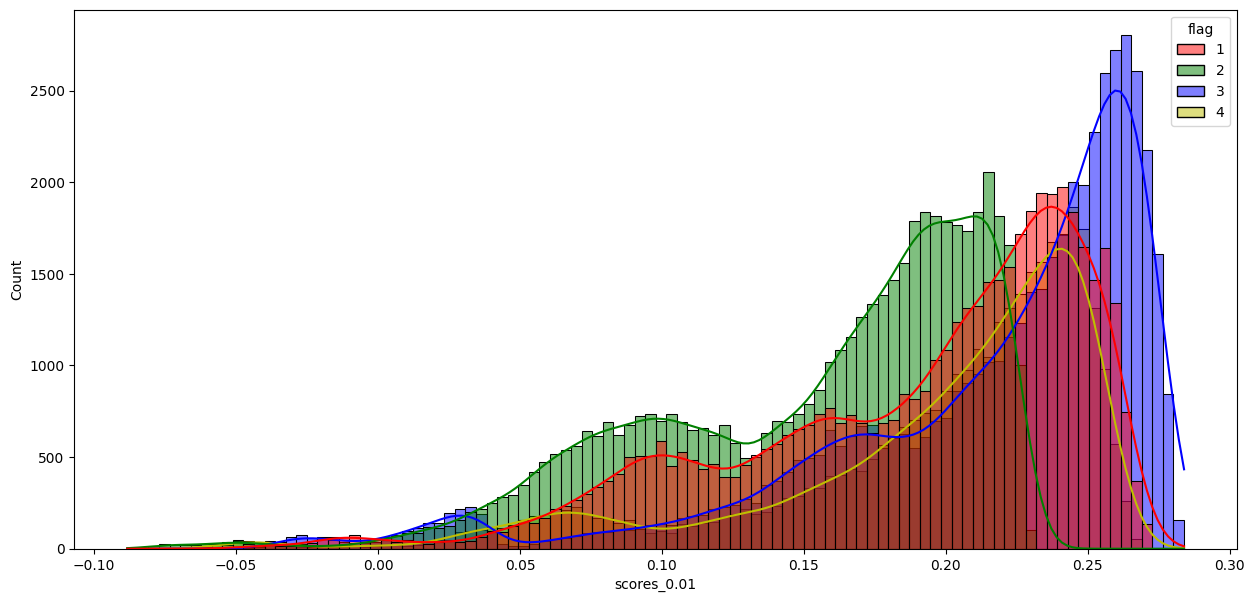

In [59]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'flag', palette=['r','g','b','y'], data = df_final_copy, bins = 100, kde = True)
fig.show()

In [60]:
plt.figure(figsize=(15, 7))
sns.histplot(x = 'scores_0.01',hue = 'anomaly_score_0.01', palette=['r','b'], data = df_final_copy, bins = 100, kde = True)
fig.show()

In [61]:
df_final_copy[df_final_copy['anomaly_score_0.01']==-1]['flag'].value_counts()

flag
1    503
2    503
3    503
4    349
Name: count, dtype: int64

In [62]:
df_final_copy[df_final_copy['anomaly_score_0.04']==-1]['flag'].value_counts()

flag
1    2012
2    2012
3    2012
4    1395
Name: count, dtype: int64

In [63]:
data = df_final_copy[df_final_copy['anomaly_score_0.01']==-1]

In [64]:

wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2)]
len(wd)

503

In [65]:
# Thresholding on scores ( < 0.04)

wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.04)]
len(wd2)

298

In [66]:
# Thresholding on scores ( < 0.05)

wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.01'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.01']<-0.05)]
len(wd3)

205

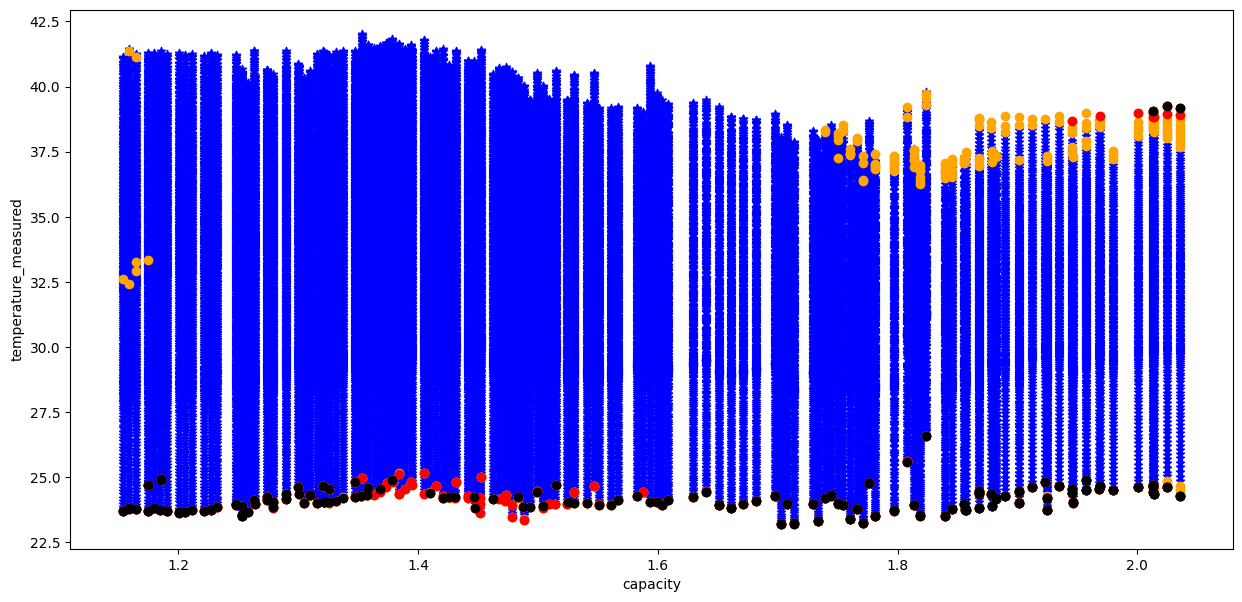

In [67]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['capacity'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('capacity')
plt.ylabel('temperature_measured')
plt.show()

- Batteries with much higher capacities and much lower capacities but having minimum temperature measured are having most critical number of outliers
- Whereas as the batteries with least temperature measured are having more number of outliers.


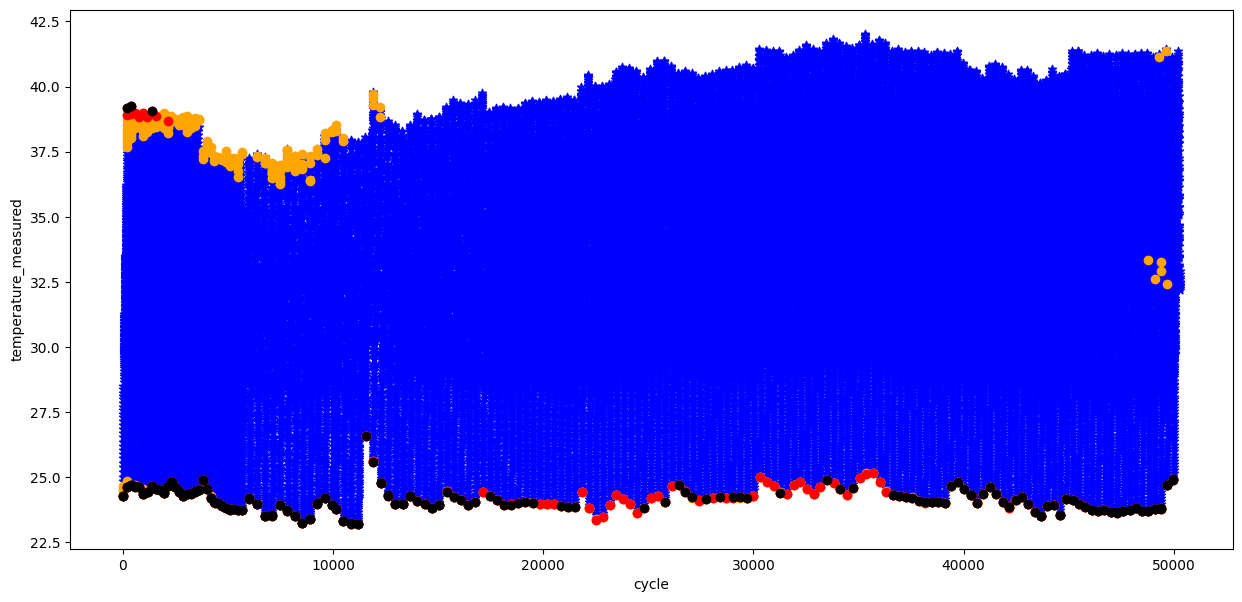

In [68]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['cycle'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['temperature_measured'], c = 'blue', marker = "*")

plt.scatter(wd['cycle'], wd['temperature_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['cycle'], wd2['temperature_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['cycle'], wd3['temperature_measured'], c = 'black', marker = 'o')

plt.xlabel('cycle')
plt.ylabel('temperature_measured')
plt.show()

- The batteries with least temperature measured are having more number of outliers.


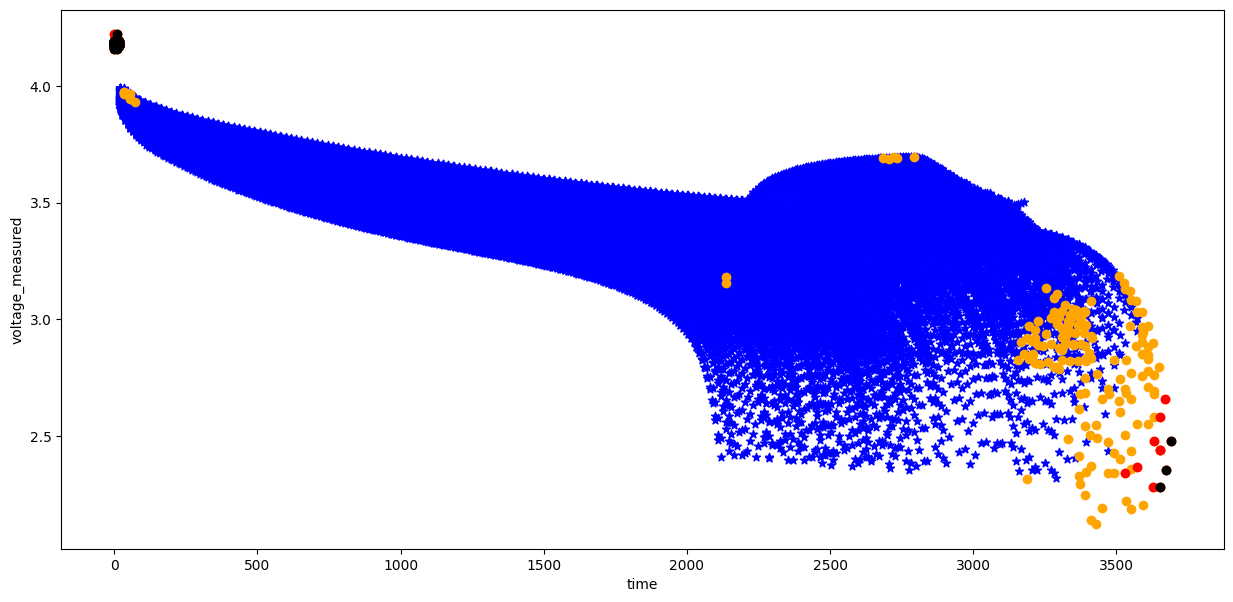

In [69]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.01'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- Batteries datapoints which are producing maximum voltages with barely minimum charging time are ceratinly outliers/anomalies.
- Also, with least contamination, the Batteries datapoints which requires maximum time to charge ceratinly outliers/anomalies.


In [70]:
# Testing with multiple values such as with  anomaly_score_0.04

wd = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2)]
wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.04)]
wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_0.04'] == -1) & (df_final_copy['flag'] == 2) & (df_final_copy['scores_0.04']<-0.05)]

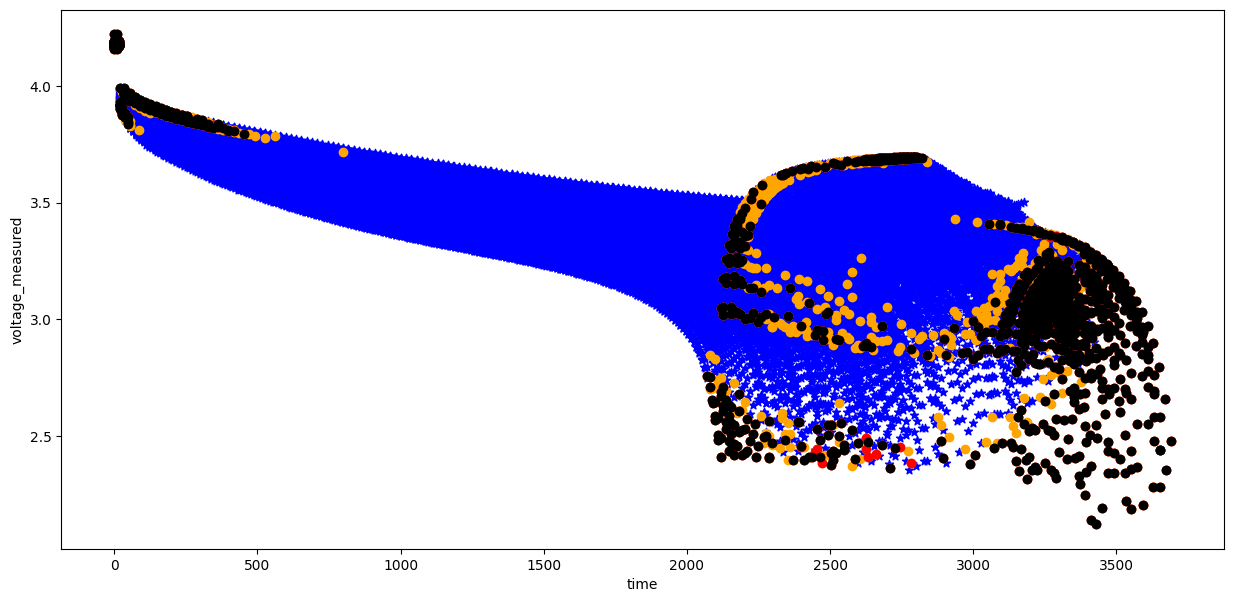

In [71]:
plt.figure(figsize=(15, 7))
plt.scatter(df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['time'],
           df_final_copy[(df_final_copy['anomaly_score_0.04'] == 1) & (df_final_copy['flag'] == 2)]['voltage_measured'], c = 'blue', marker = "*")

plt.scatter(wd['time'], wd['voltage_measured'], c = 'orange', marker = 'o')
plt.scatter(wd2['time'], wd2['voltage_measured'], c = 'red', marker = 'o')
plt.scatter(wd3['time'], wd3['voltage_measured'], c = 'black', marker = 'o')

plt.xlabel('time')
plt.ylabel('voltage_measured')
plt.show()

- As it's clearly visible, if we increase the contamination % of outliers to 4% , it's able to classify the visually seen anomalies as outliers as compared to contamination of 1%
- Also, with max contamination of 4%, the Batteries datapoints which requires maximum time to charge and whose voltages are low are certainly outliers/anomalies.


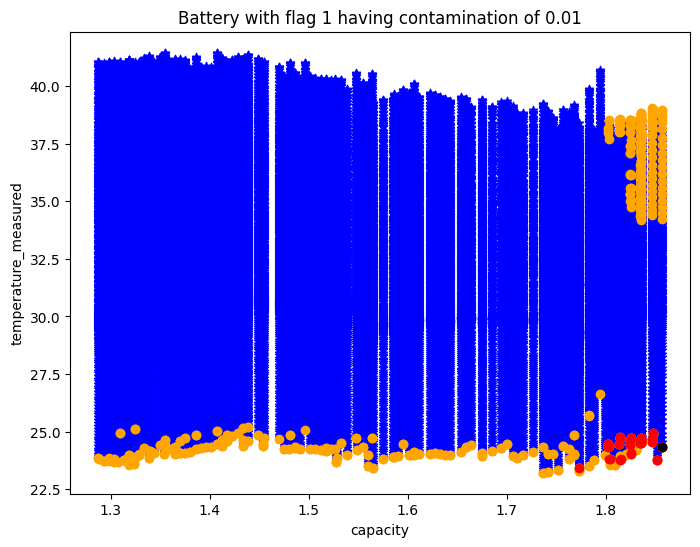

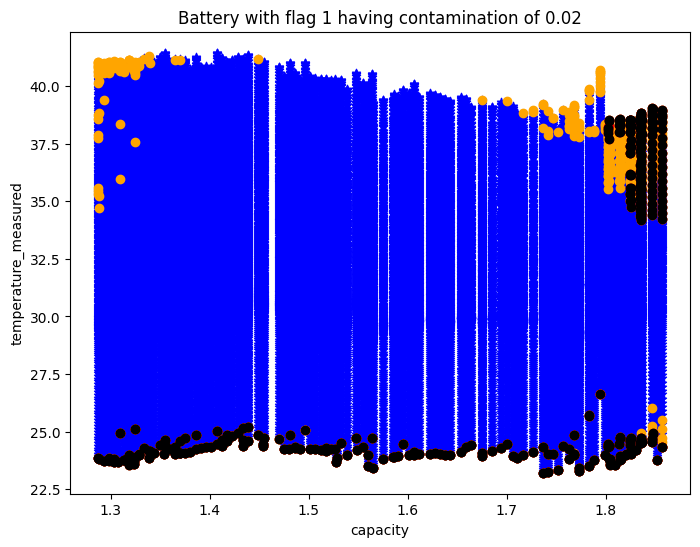

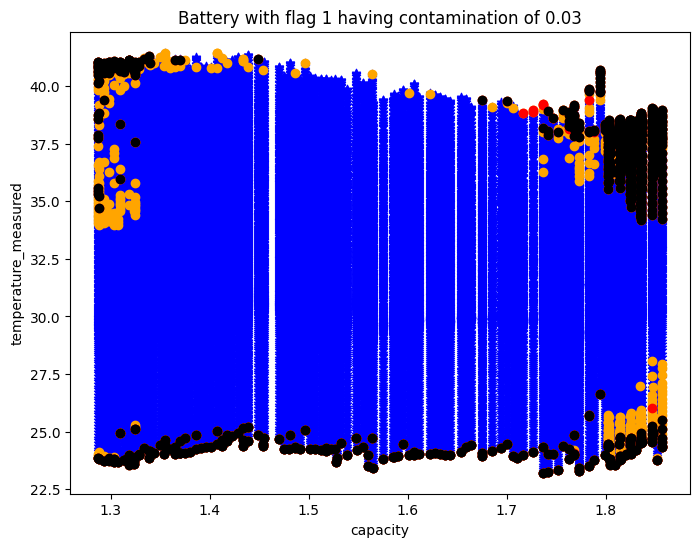

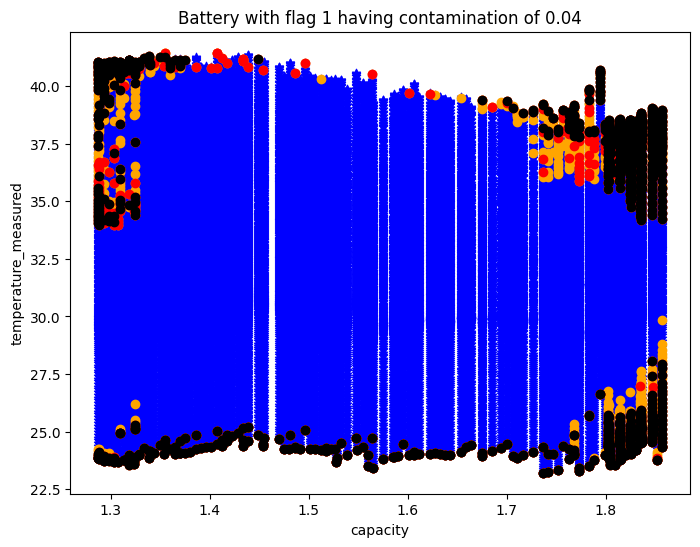

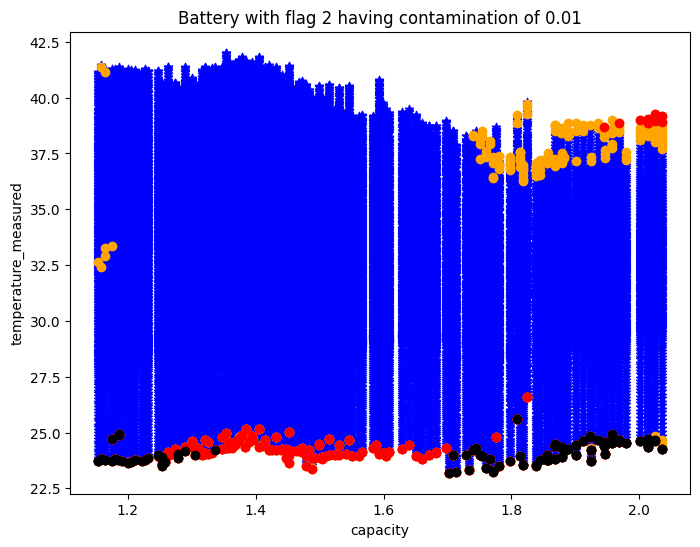

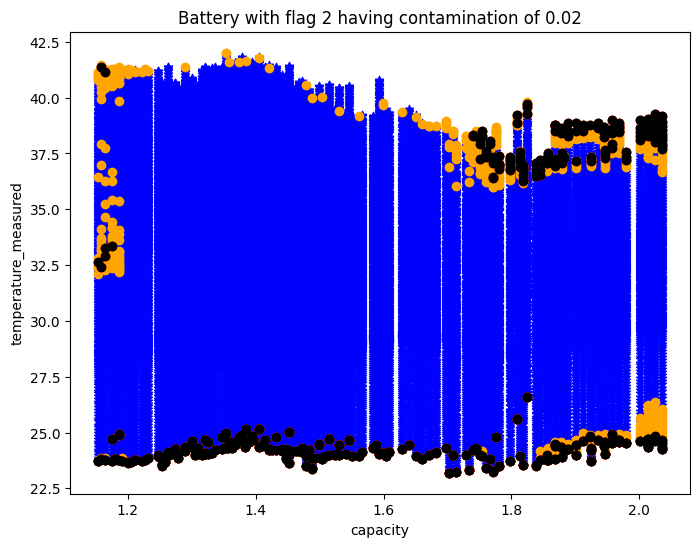

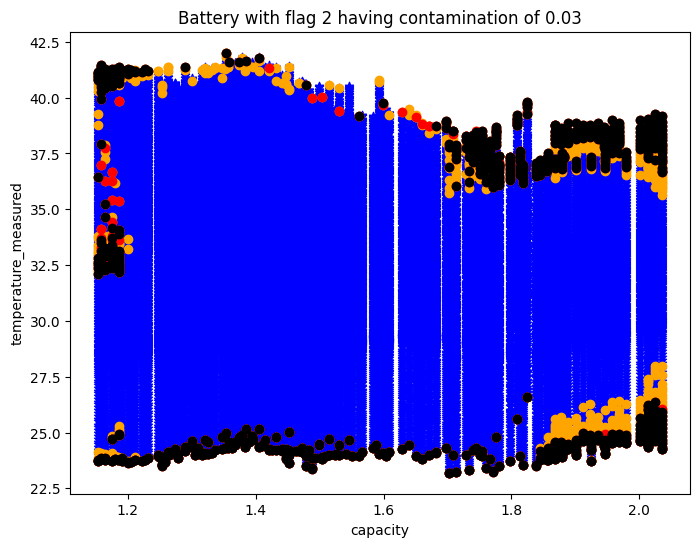

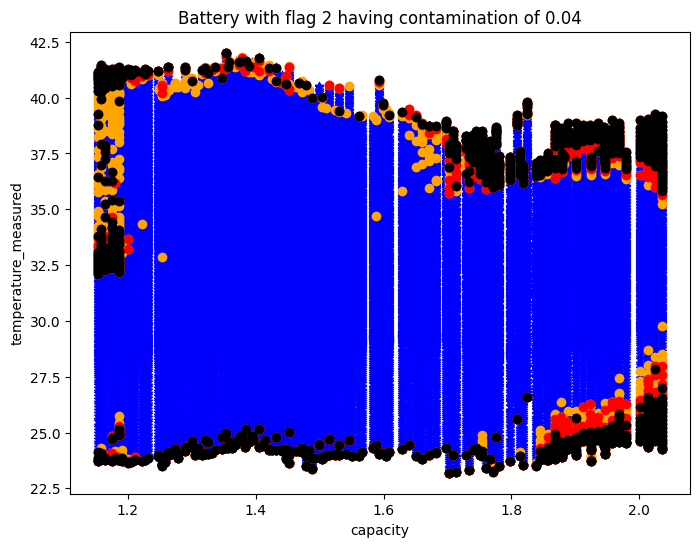

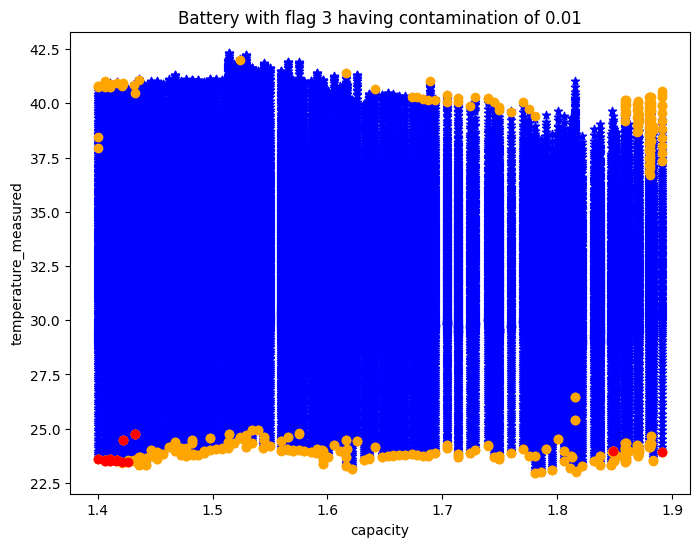

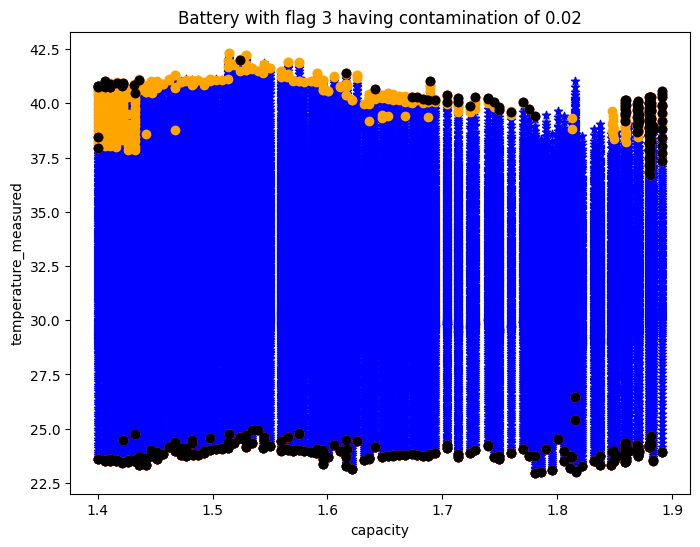

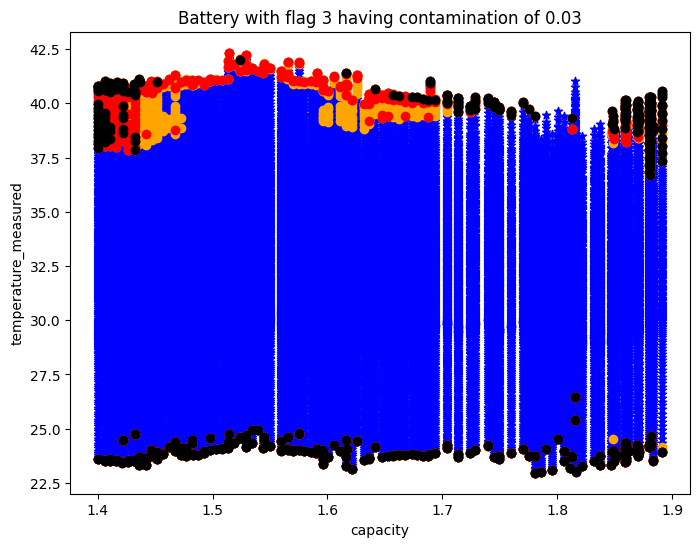

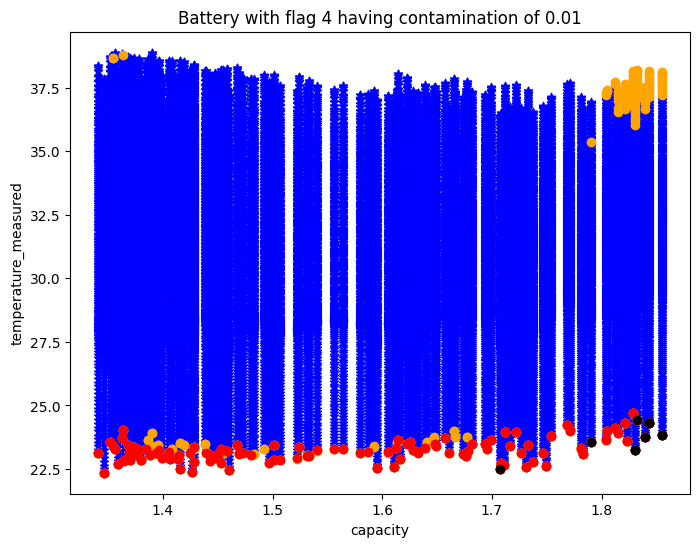

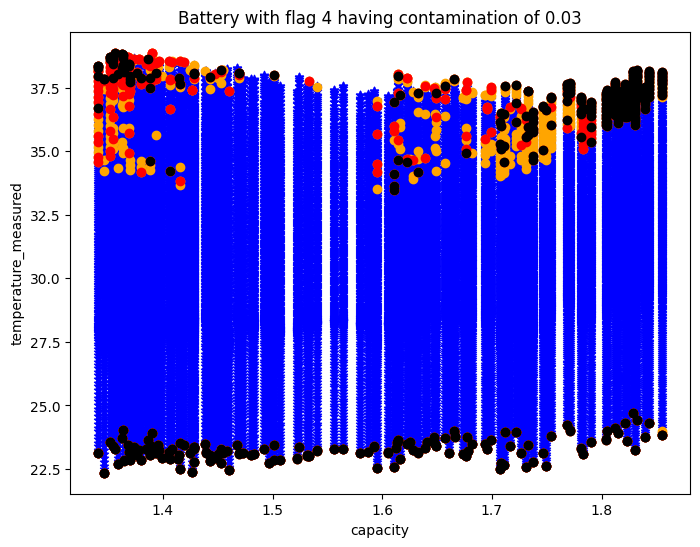

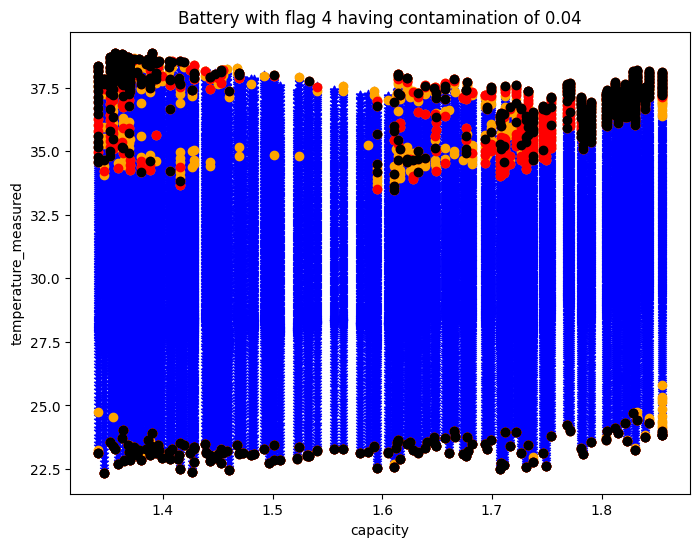

In [72]:
flags_arr = [1,2,3,4]
contamination_arr = [0.01,0.02,0.03,0.04]

for i in flags_arr:
    for j in contamination_arr:
        wd = df_final_copy.loc[(df_final_copy['anomaly_score_'+str(j)] == -1) & (df_final_copy['flag'] == i)]
        wd2 = df_final_copy.loc[(df_final_copy['anomaly_score_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.04)]
        wd3 = df_final_copy.loc[(df_final_copy['anomaly_score_'+str(j)] == -1) & (df_final_copy['flag'] == i) & (df_final_copy['scores'+'_'+str(j)]<-0.06)]
        
        plt.figure(figsize=(8, 6))
        plt.scatter(df_final_copy[(df_final_copy['anomaly_score_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['capacity'],
                   df_final_copy[(df_final_copy['anomaly_score_'+str(j)] == 1) & (df_final_copy['flag'] == i)]['temperature_measured'], c = 'blue', marker = "*")

        plt.scatter(wd['capacity'], wd['temperature_measured'], c = 'orange', marker = 'o')
        plt.scatter(wd2['capacity'], wd2['temperature_measured'], c = 'red', marker = 'o')
        plt.scatter(wd3['capacity'], wd3['temperature_measured'], c = 'black', marker = 'o')

        plt.xlabel('capacity')
        plt.ylabel('temperature_measured')
        plt.title('Battery with flag ' + str(i)+ ' having contamination of '+str(j))
        plt.show()

- The batteries with least temperature measured are having more number of outliers.
- Batteries with much higher capacities and much lower capacities but having minimum temperature measured are having most critical number of outliers
- Whereas as the batteries with least temperature measured are having more number of outliers.
- As we go on increase the contamination %, we are getting more number of datapoints classified as extreme outliers.


#### Local Outlier Factor (LOF) based anomaly detection

In [73]:
lof_df = fuel_cells_df_copy2.copy()

n_neighbors = [5, 20]
contamination_arr = [0.01,0.04]
flags_arr = [1,2,3,4]

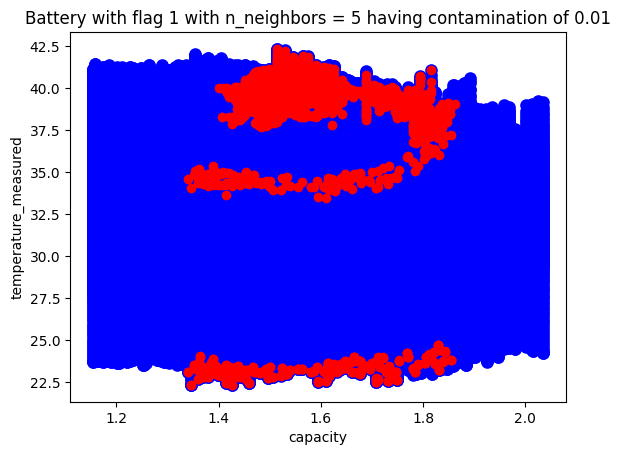

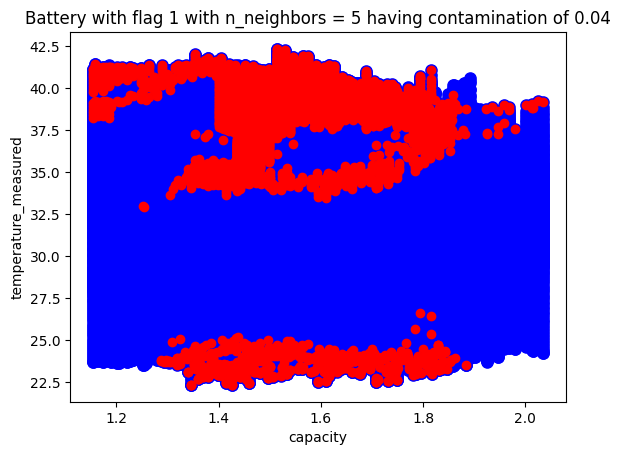

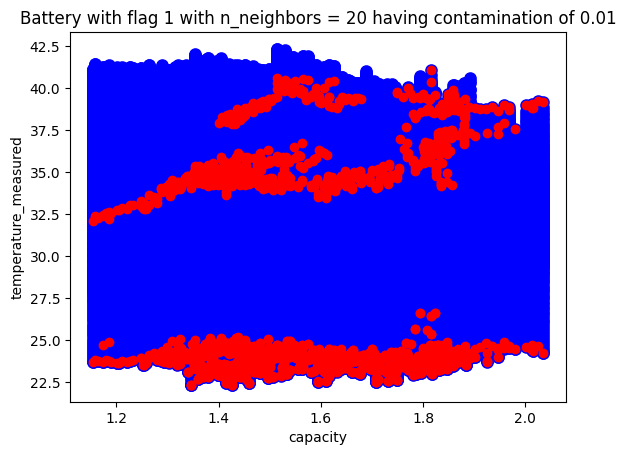

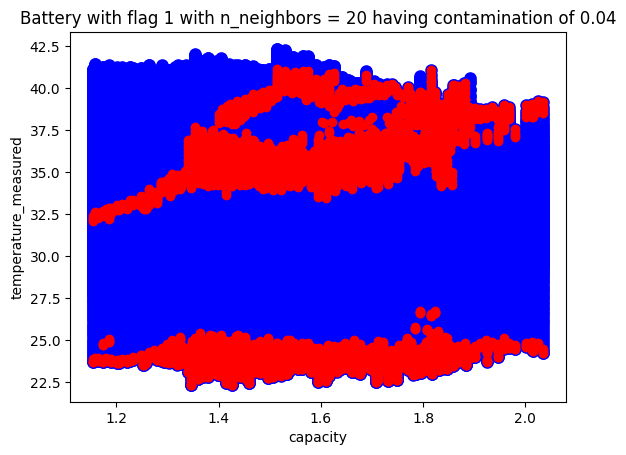

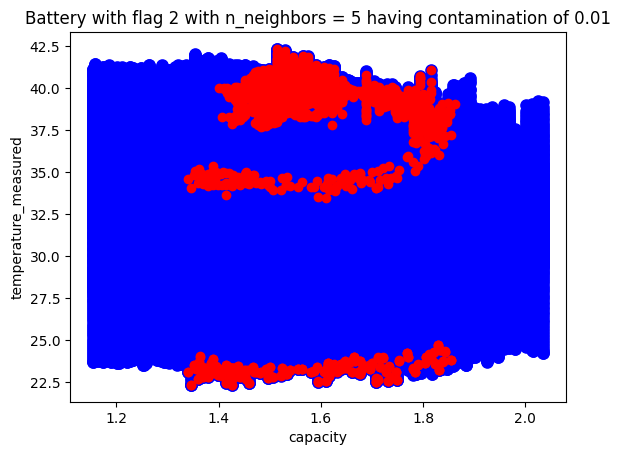

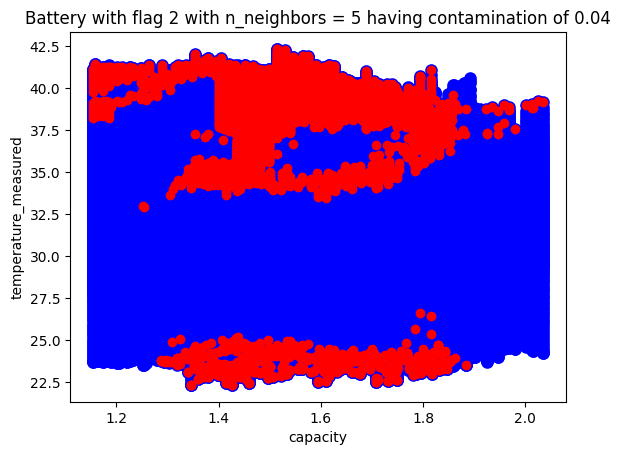

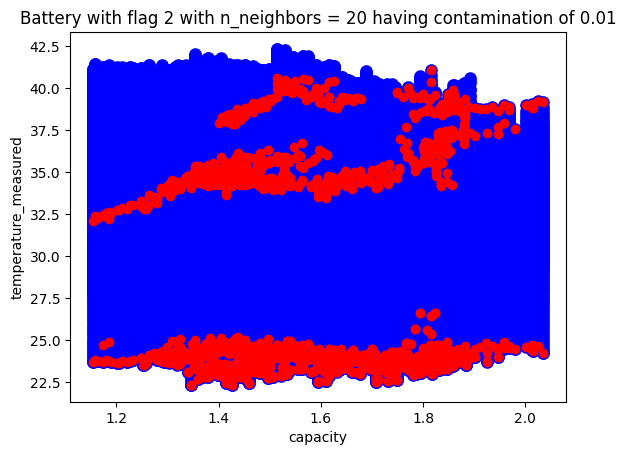

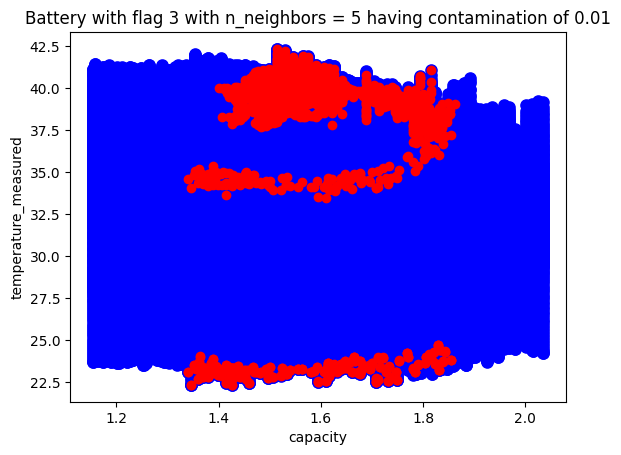

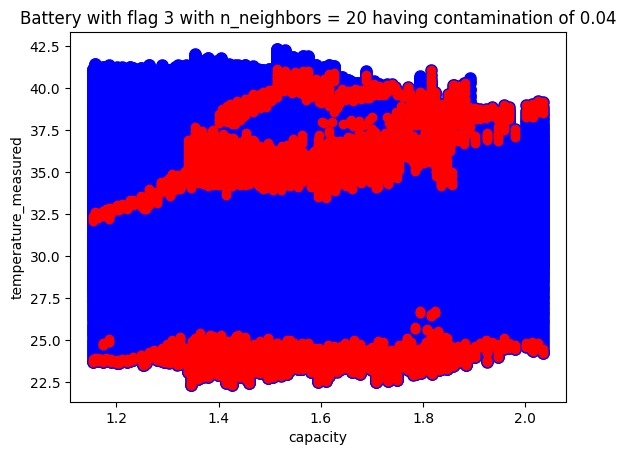

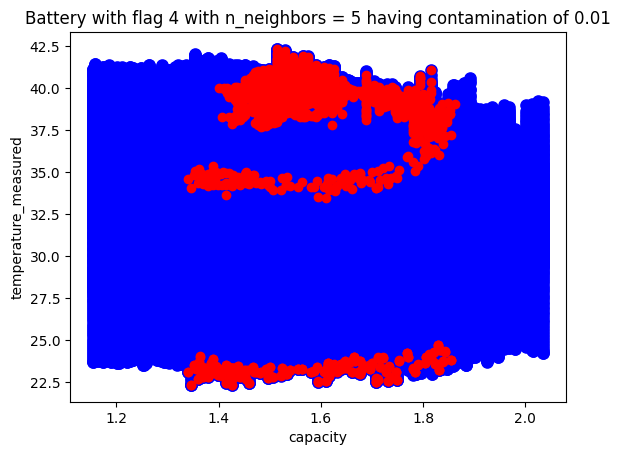

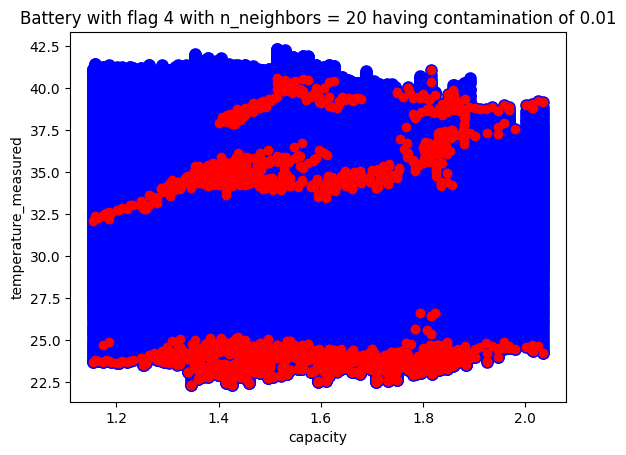

In [74]:
from sklearn.neighbors import LocalOutlierFactor
for f in flags_arr:
    for n in n_neighbors:
        for c in contamination_arr:
            # model specification
            model1 = LocalOutlierFactor(n_neighbors = n, metric = "manhattan", contamination = c)
            # model fitting
            y_pred = model1.fit_predict(fuel_cells_df_copy2)
            # filter outlier index
            outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
            # filter outlier values
            outlier_values = fuel_cells_df_copy2.iloc[outlier_index]
            # plot data
            plt.scatter(fuel_cells_df_copy2["capacity"], fuel_cells_df_copy2["temperature_measured"], color = "b", s = 65)
            # plot outlier values
            plt.scatter(outlier_values["capacity"], outlier_values["temperature_measured"], color = "r") 
            plt.xlabel('capacity')
            plt.ylabel('temperature_measured')
            plt.title('Battery with flag ' + str(f)+ ' with n_neighbors = '+ str(n)+' having contamination of '+str(c))
            plt.show()

- Almost 7429 datapoints are getting classified as outliers using maximum nearest neigbors (20) and with higesht contamination percentage of 4%.
- With least nearest neigbors and least contamination percentage, we are getting less no. of outliers specifically in the mid-battery capacity range (1.4-1.6) having least and maximum temperature measured. This can be informed to subject matter expert and thus can be validated before removal.


In [75]:
len(y_pred)

185721

In [76]:
y_pred_df = pd.DataFrame(data=y_pred,columns=['y_pred'])
fuel_cells_df_copy2_final_lof = pd.concat([fuel_cells_df_copy2,y_pred_df],axis = 1)
fuel_cells_df_copy2_final_lof

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           2  1207149941000000000  1.856487          4.190749   
2           3  1207149941000000000  1.856487          3.974871   
3           4  1207149941000000000  1.856487          3.951717   
4           5  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716  34862  1219221439000000000  1.341051          3.443760   
185717  34863  1219221439000000000  1.341051          3.453271   
185718  34864  1219221439000000000  1.341051          3.461963   
185719  34865  1219221439000000000  1.341051          3.469907   
185720  34866  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  y_pred  
0          0.000     1      -1  
1         16.781     1      -1  
2         35.703     1      -1  
3         53.781     1      -1  
4         71.922     1       1  
...          ...   ...     ...  
185716  2686.359     4      -1  
185717  2700.546     4      -1  
185718  2714.640     4      -1  
185719  2728.750     4      -1  
185720  2742.843     4      -1  

[185721 rows x 11 columns]

In [77]:
# No. of outliers when we are considering the highest contamoination i.e 4 %

fuel_cells_df_copy2_final_lof[fuel_cells_df_copy2_final_lof['y_pred'] == -1]

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           2  1207149941000000000  1.856487          4.190749   
2           3  1207149941000000000  1.856487          3.974871   
3           4  1207149941000000000  1.856487          3.951717   
193       194  1207149941000000000  1.856487          3.264121   
...       ...                  ...       ...               ...   
185716  34862  1219221439000000000  1.341051          3.443760   
185717  34863  1219221439000000000  1.341051          3.453271   
185718  34864  1219221439000000000  1.341051          3.461963   
185719  34865  1219221439000000000  1.341051          3.469907   
185720  34866  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
193            -0.001532             35.021738       -0.0006         0.000   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  y_pred  
0          0.000     1      -1  
1         16.781     1      -1  
2         35.703     1      -1  
3         53.781     1      -1  
193     3628.953     1      -1  
...          ...   ...     ...  
185716  2686.359     4      -1  
185717  2700.546     4      -1  
185718  2714.640     4      -1  
185719  2728.750     4      -1  
185720  2742.843     4      -1  

[7429 rows x 11 columns]

In [78]:
plt.figure(figsize=(15, 7))
plt.scatter(fuel_cells_df_copy2_final_lof['time'], fuel_cells_df_copy2_final_lof['voltage_measured'], c=fuel_cells_df_copy2_final_lof['y_pred'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

- Validated visually in lower dimension with above hyperparameters but the performance is less acuurate than Isolation Forest but more accurate than other methods.


### Elliptical Envelope based Anomaly Detection

In [79]:
eliptical_df = fuel_cells_df_copy2.copy()

In [80]:
from sklearn.preprocessing import StandardScaler
cols = ['cycle', 'datetime', 'capacity', 'voltage_measured', 'current_measured',
       'temperature_measured', 'current_load', 'voltage_load', 'time', 'flag']
scaler = StandardScaler()

eliptical_df[cols] = scaler.fit_transform(eliptical_df[cols])
eliptical_df.head()

cycle  datetime  capacity  voltage_measured  current_measured  \
0 -1.678666 -1.424022  1.477315          2.758442          3.255533   
1 -1.678595 -1.424022  1.477315          2.755491          3.261632   
2 -1.678524 -1.424022  1.477315          1.897777         -0.320553   
3 -1.678453 -1.424022  1.477315          1.805782         -0.323138   
4 -1.678383 -1.424022  1.477315          1.736792         -0.318086   

   temperature_measured  current_load  voltage_load      time      flag  
0             -1.998389     -1.194938     -3.149552 -1.705022 -1.281811  
1             -1.999392     -1.194938      2.448187 -1.686519 -1.281811  
2             -1.983728     -2.823146      0.925645 -1.665656 -1.281811  
3             -1.945079     -2.823146      0.883056 -1.645723 -1.281811  
4             -1.898742     -2.823146      0.857769 -1.625721 -1.281811

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test= train_test_split(eliptical_df, test_size=0.33, random_state=42)

data = X_train[cols].values

In [83]:
from sklearn.covariance import EllipticEnvelope

model1 = EllipticEnvelope(contamination = 0.1) 
model1.fit(data)

EllipticEnvelope()

In [84]:
# new data for prediction (data needs to be in arrays)
new_data = X_test[cols].values

# predict on new data 
pred1 = model1.predict(new_data)
print(pred1)

[1 1 1 ... 1 1 1]


In [85]:
len(new_data), len(pred1)

(61288, 61288)

In [86]:
pred_df = pd.DataFrame(data=pred1,columns=['pred1'])
fuel_cells_df_copy2_final_eliptical = pd.concat([X_test,pred_df],axis = 1)

pred_df

pred1
0          1
1          1
2          1
3          1
4          1
...      ...
61283      1
61284      1
61285      1
61286      1
61287      1

[61288 rows x 1 columns]

In [87]:
fuel_cells_df_copy2_final_eliptical[fuel_cells_df_copy2_final_eliptical['pred1'] == -1].shape

(5943, 11)

In [88]:
all_data = eliptical_df[cols].values
pred2 = model1.predict(all_data)
print(pred2)

[ 1  1 -1 ... -1 -1 -1]


In [89]:
len(pred2), len(all_data)

(185721, 185721)

In [90]:
pred_df_all = pd.DataFrame(data=pred2,columns=['pred2'])
final_eliptical = pd.concat([fuel_cells_df_copy2,pred_df_all],axis = 1)
final_eliptical

cycle             datetime  capacity  voltage_measured  \
0           1  1207149941000000000  1.856487          4.191492   
1           2  1207149941000000000  1.856487          4.190749   
2           3  1207149941000000000  1.856487          3.974871   
3           4  1207149941000000000  1.856487          3.951717   
4           5  1207149941000000000  1.856487          3.934352   
...       ...                  ...       ...               ...   
185716  34862  1219221439000000000  1.341051          3.443760   
185717  34863  1219221439000000000  1.341051          3.453271   
185718  34864  1219221439000000000  1.341051          3.461963   
185719  34865  1219221439000000000  1.341051          3.469907   
185720  34866  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
0              -0.004902             24.330034       -0.0006         0.000   
1              -0.001478             24.325993       -0.0006         4.206   
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  pred2  
0          0.000     1      1  
1         16.781     1      1  
2         35.703     1     -1  
3         53.781     1     -1  
4         71.922     1     -1  
...          ...   ...    ...  
185716  2686.359     4     -1  
185717  2700.546     4     -1  
185718  2714.640     4     -1  
185719  2728.750     4     -1  
185720  2742.843     4     -1  

[185721 rows x 11 columns]

In [91]:
final_eliptical[final_eliptical['pred2'] == -1]

cycle             datetime  capacity  voltage_measured  \
2           3  1207149941000000000  1.856487          3.974871   
3           4  1207149941000000000  1.856487          3.951717   
4           5  1207149941000000000  1.856487          3.934352   
5           6  1207149941000000000  1.856487          3.920058   
6           7  1207149941000000000  1.856487          3.907904   
...       ...                  ...       ...               ...   
185716  34862  1219221439000000000  1.341051          3.443760   
185717  34863  1219221439000000000  1.341051          3.453271   
185718  34864  1219221439000000000  1.341051          3.461963   
185719  34865  1219221439000000000  1.341051          3.469907   
185720  34866  1219221439000000000  1.341051          3.477277   

        current_measured  temperature_measured  current_load  voltage_load  \
2              -2.012528             24.389085       -1.9982         3.062   
3              -2.013979             24.544752       -1.9982         3.030   
4              -2.011144             24.731385       -1.9982         3.011   
5              -2.013007             24.909816       -1.9982         2.991   
6              -2.014400             25.105884       -1.9982         2.977   
...                  ...                   ...           ...           ...   
185716         -0.002426             35.383979        0.0006         0.000   
185717         -0.000981             35.179732        0.0006         0.000   
185718          0.000209             34.977000        0.0006         0.000   
185719          0.001516             34.785943        0.0006         0.000   
185720         -0.001940             34.581660        0.0006         0.000   

            time  flag  pred2  
2         35.703     1     -1  
3         53.781     1     -1  
4         71.922     1     -1  
5         90.094     1     -1  
6        108.281     1     -1  
...          ...   ...    ...  
185716  2686.359     4     -1  
185717  2700.546     4     -1  
185718  2714.640     4     -1  
185719  2728.750     4     -1  
185720  2742.843     4     -1  

[18387 rows x 11 columns]

In [92]:
plt.figure(figsize=(15, 7))
plt.scatter(final_eliptical['time'], final_eliptical['voltage_measured'], c=final_eliptical['pred2'])
plt.xlabel('time of battery charging')
plt.ylabel('voltage_measured')
plt.show()

### Comparison

_Isolation Forest >> Local Outlier Factor (LOF) > DBSCAN (density based) > Elliptical Envelope >> IQR based_